# Classification (clean up from classification notebook)

## Import libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import re

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

## import model objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit

In [2]:
#seed = np.random.seed(22)
seed = 1

## Read files

In [3]:
df = pd.read_csv('../Data/dataset_others_class.csv')
df = df.rename(columns={'F_Close_pred_class':'Prediction'})
df

Date  CADUSD=X_Open  CADUSD=X_Close  CADUSD=X_High  \
0     2019-11-26 00:00:00+00:00       0.751665        0.751705       0.752842   
1     2019-11-27 00:00:00+00:00       0.753597        0.753636       0.754205   
2     2019-11-29 00:00:00+00:00       0.753125        0.753029       0.753211   
3     2019-12-02 00:00:00+00:00       0.752734        0.752791       0.753296   
4     2019-12-03 00:00:00+00:00       0.751552        0.751710       0.752899   
...                         ...            ...             ...            ...   
1232  2024-10-22 00:00:00+00:00       0.722883        0.722883       0.723877   
1233  2024-10-23 00:00:00+00:00       0.723788        0.723788       0.723809   
1234  2024-10-24 00:00:00+00:00       0.722716        0.722716       0.724008   
1235  2024-10-25 00:00:00+00:00       0.721850        0.721850       0.722648   
1236  2024-10-28 00:00:00+00:00       0.719652        0.719652       0.720326   

      CADUSD=X_Low  CADUSD=X_Volume  CADUSD=X_Change  CADUSD=X_Gain  \
0         0.750999              0.0        -0.000418       0.000000   
1         0.752502              0.0         0.001932       0.001932   
2         0.751145              0.0        -0.000607       0.000000   
3         0.751569              0.0        -0.000238       0.000000   
4         0.750728              0.0        -0.001081       0.000000   
...            ...              ...              ...            ...   
1232      0.722684              0.0        -0.001776       0.000000   
1233      0.721433              0.0         0.000905       0.000905   
1234      0.721480              0.0        -0.001072       0.000000   
1235      0.720170              0.0        -0.000866       0.000000   
1236      0.719031              0.0        -0.002197       0.000000   

      CADUSD=X_Loss  CADUSD=X_Avg_Gain  ...      F_RSI  F_k_percent  \
0          0.000418           0.000289  ...  62.087549    73.913071   
1          0.000000           0.000427  ...  67.610216    89.583482   
2          0.000607           0.000427  ...  62.910674    81.250149   
3          0.000238           0.000419  ...  57.178300    70.833433   
4          0.001081           0.000419  ...  45.657569    45.833433   
...             ...                ...  ...        ...          ...   
1232       0.001776           0.000308  ...  63.192190    91.764633   
1233       0.000000           0.000245  ...  59.825069    80.219848   
1234       0.001072           0.000245  ...  67.105734    98.850548   
1235       0.000866           0.000245  ...  56.038726    72.631549   
1236       0.002197           0.000245  ...  67.090123    97.894690   

      F_r_percent    F_MACD  F_MACD_EMA     F_ROC         F_PVT  \
0      -26.086929  0.006892    0.002249 -0.331855  2.394865e+06   
1      -10.416518  0.019164    0.005663  0.220269  2.768411e+06   
2      -18.749851  0.025755    0.009711  0.221244  2.710846e+06   
3      -29.166567  0.027163    0.013223  2.270145  2.505366e+06   
4      -54.166567  0.019687    0.014522  1.137661  1.963927e+06   
...           ...       ...         ...       ...           ...   
1232    -8.235367  0.063288    0.007636  6.315788  6.779642e+07   
1233   -19.780152  0.071755    0.020460  4.635769  6.762839e+07   
1234    -1.149452  0.091931    0.034754  7.149667  6.835647e+07   
1235   -27.368451  0.093129    0.046429  4.237286  6.776479e+07   
1236    -2.105310  0.116938    0.060531  6.460670  7.041972e+07   

      F_Bollinger_Upper  F_Bollinger_Lower  Prediction  
0              9.188927           8.586074           1  
1              9.183159           8.647842           0  
2              9.165730           8.712270           0  
3              9.172619           8.717381           0  
4              9.166840           8.712161           1  
...                 ...                ...         ...  
1232          11.195281          10.306719           0  
1233          11.223237          10.297763           1  
1234          11.282170       

In [4]:
tickers = []
for col in df.columns:
    if '_RSI' in col:
        tickers.append(col.split('_')[0])

tickers.pop()
tickers

['CADUSD=X', 'GM', 'JCI', 'TM', 'TRYUSD=X', '^IXIC']

In [5]:
## Remove open, close, high, low, vol columns
open_cols = [col for col in df.columns if '_Open' in col]
close_cols = [col for col in df.columns if '_Close' in col]
high_cols = [col for col in df.columns if '_High' in col]

regex = '_Low$' # to avoid dropping _Bollinger_Lower
low_cols = df.columns[df.columns.str.contains(regex, case=False, na=False, regex=True)]
vol_cols = [col for col in df.columns if '_Volume' in col]

df = df.drop(columns=open_cols)
df = df.drop(columns=close_cols)
df = df.drop(columns=high_cols)
df = df.drop(columns=low_cols)
df = df.drop(columns=vol_cols)

In [6]:
df

Date  CADUSD=X_Change  CADUSD=X_Gain  \
0     2019-11-26 00:00:00+00:00        -0.000418       0.000000   
1     2019-11-27 00:00:00+00:00         0.001932       0.001932   
2     2019-11-29 00:00:00+00:00        -0.000607       0.000000   
3     2019-12-02 00:00:00+00:00        -0.000238       0.000000   
4     2019-12-03 00:00:00+00:00        -0.001081       0.000000   
...                         ...              ...            ...   
1232  2024-10-22 00:00:00+00:00        -0.001776       0.000000   
1233  2024-10-23 00:00:00+00:00         0.000905       0.000905   
1234  2024-10-24 00:00:00+00:00        -0.001072       0.000000   
1235  2024-10-25 00:00:00+00:00        -0.000866       0.000000   
1236  2024-10-28 00:00:00+00:00        -0.002197       0.000000   

      CADUSD=X_Loss  CADUSD=X_Avg_Gain  CADUSD=X_Avg_Loss  CADUSD=X_SMA  \
0          0.000418           0.000289           0.000910      0.756581   
1          0.000000           0.000427           0.000767      0.756063   
2          0.000607           0.000427           0.000641      0.755736   
3          0.000238           0.000419           0.000658      0.755404   
4          0.001081           0.000419           0.000707      0.754937   
...             ...                ...                ...           ...   
1232       0.001776           0.000308           0.001477      0.733303   
1233       0.000000           0.000245           0.001477      0.732536   
1234       0.001072           0.000245           0.001513      0.731416   
1235       0.000866           0.000245           0.001406      0.730423   
1236       0.002197           0.000245           0.001293      0.729302   

      CADUSD=X_EMA  CADUSD=X_change_in_price  CADUSD=X_RSI  ...      F_RSI  \
0         0.756180                 -0.000418     27.821853  ...  62.087549   
1         0.755938                  0.001932     42.880806  ...  67.610216   
2         0.755661                 -0.000607     39.864127  ...  62.910674   
3         0.755387                 -0.000238     38.634678  ...  57.178300   
4         0.755037                 -0.001081     33.260985  ...  45.657569   
...            ...                       ...           ...  ...        ...   
1232      0.730472                 -0.001776     22.129881  ...  63.192190   
1233      0.729835                  0.000905     28.290869  ...  59.825069   
1234      0.729157                 -0.001072     25.529720  ...  67.105734   
1235      0.728461                 -0.000866     23.401396  ...  56.038726   
1236      0.727622                 -0.002197     18.810221  ...  67.090123   

      F_k_percent  F_r_percent    F_MACD  F_MACD_EMA     F_ROC         F_PVT  \
0       73.913071   -26.086929  0.006892    0.002249 -0.331855  2.394865e+06   
1       89.583482   -10.416518  0.019164    0.005663  0.220269  2.768411e+06   
2       81.250149   -18.749851  0.025755    0.009711  0.221244  2.710846e+06   
3       70.833433   -29.166567  0.027163    0.013223  2.270145  2.505366e+06   
4       45.833433   -54.166567  0.019687    0.014522  1.137661  1.963927e+06   
...           ...          ...       ...         ...       ...           ...   
1232    91.764633    -8.235367  0.063288    0.007636  6.315788  6.779642e+07   
1233    80.219848   -19.780152  0.071755    0.020460  4.635769  6.762839e+07   
1234    98.850548    -1.149452  0.091931    0.034754  7.149667  6.835647e+07   
1235    72.631549   -27.368451  0.093129    0.046429  4.237286  6.776479e+07   
1236    97.894690    -2.105310  0.116938    0.060531  6.460670  7.041972e+07   

      F_Bollinger_Upper  F_Bollinger_Lower  Prediction  
0              9.188927           8.586074           1  
1              9.183159           8.647842           0  
2              9.165730           8.712270           0  
3              9.172619           8.717381           0  
4              9.166840           8.712161           1  
...                 ...                ...         ...  
1232          11.195281 

In [7]:
regex = '_Low$'
df.columns[df.columns.str.contains(regex, case=False, na=False, regex=True)]

Index([], dtype='object')

In [8]:
df

Date  CADUSD=X_Change  CADUSD=X_Gain  \
0     2019-11-26 00:00:00+00:00        -0.000418       0.000000   
1     2019-11-27 00:00:00+00:00         0.001932       0.001932   
2     2019-11-29 00:00:00+00:00        -0.000607       0.000000   
3     2019-12-02 00:00:00+00:00        -0.000238       0.000000   
4     2019-12-03 00:00:00+00:00        -0.001081       0.000000   
...                         ...              ...            ...   
1232  2024-10-22 00:00:00+00:00        -0.001776       0.000000   
1233  2024-10-23 00:00:00+00:00         0.000905       0.000905   
1234  2024-10-24 00:00:00+00:00        -0.001072       0.000000   
1235  2024-10-25 00:00:00+00:00        -0.000866       0.000000   
1236  2024-10-28 00:00:00+00:00        -0.002197       0.000000   

      CADUSD=X_Loss  CADUSD=X_Avg_Gain  CADUSD=X_Avg_Loss  CADUSD=X_SMA  \
0          0.000418           0.000289           0.000910      0.756581   
1          0.000000           0.000427           0.000767      0.756063   
2          0.000607           0.000427           0.000641      0.755736   
3          0.000238           0.000419           0.000658      0.755404   
4          0.001081           0.000419           0.000707      0.754937   
...             ...                ...                ...           ...   
1232       0.001776           0.000308           0.001477      0.733303   
1233       0.000000           0.000245           0.001477      0.732536   
1234       0.001072           0.000245           0.001513      0.731416   
1235       0.000866           0.000245           0.001406      0.730423   
1236       0.002197           0.000245           0.001293      0.729302   

      CADUSD=X_EMA  CADUSD=X_change_in_price  CADUSD=X_RSI  ...      F_RSI  \
0         0.756180                 -0.000418     27.821853  ...  62.087549   
1         0.755938                  0.001932     42.880806  ...  67.610216   
2         0.755661                 -0.000607     39.864127  ...  62.910674   
3         0.755387                 -0.000238     38.634678  ...  57.178300   
4         0.755037                 -0.001081     33.260985  ...  45.657569   
...            ...                       ...           ...  ...        ...   
1232      0.730472                 -0.001776     22.129881  ...  63.192190   
1233      0.729835                  0.000905     28.290869  ...  59.825069   
1234      0.729157                 -0.001072     25.529720  ...  67.105734   
1235      0.728461                 -0.000866     23.401396  ...  56.038726   
1236      0.727622                 -0.002197     18.810221  ...  67.090123   

      F_k_percent  F_r_percent    F_MACD  F_MACD_EMA     F_ROC         F_PVT  \
0       73.913071   -26.086929  0.006892    0.002249 -0.331855  2.394865e+06   
1       89.583482   -10.416518  0.019164    0.005663  0.220269  2.768411e+06   
2       81.250149   -18.749851  0.025755    0.009711  0.221244  2.710846e+06   
3       70.833433   -29.166567  0.027163    0.013223  2.270145  2.505366e+06   
4       45.833433   -54.166567  0.019687    0.014522  1.137661  1.963927e+06   
...           ...          ...       ...         ...       ...           ...   
1232    91.764633    -8.235367  0.063288    0.007636  6.315788  6.779642e+07   
1233    80.219848   -19.780152  0.071755    0.020460  4.635769  6.762839e+07   
1234    98.850548    -1.149452  0.091931    0.034754  7.149667  6.835647e+07   
1235    72.631549   -27.368451  0.093129    0.046429  4.237286  6.776479e+07   
1236    97.894690    -2.105310  0.116938    0.060531  6.460670  7.041972e+07   

      F_Bollinger_Upper  F_Bollinger_Lower  Prediction  
0              9.188927           8.586074           1  
1              9.183159           8.647842           0  
2              9.165730           8.712270           0  
3              9.172619           8.717381           0  
4              9.166840           8.712161           1  
...                 ...                ...         ...  
1232          11.195281 

In [9]:
tickers

['CADUSD=X', 'GM', 'JCI', 'TM', 'TRYUSD=X', '^IXIC']

## Extract F columns and one of other tickers

In [10]:
def extract_cols(df, ticker: str):
    F_cols = [col for col in df.columns if 'F_' in col]
    cols = F_cols.copy()

    if ticker != 'F':
        for col in df.columns:
            if col == 'CADUSD=X_PVT' or col == 'TRYUSD=X_PVT':
                pass
            elif ticker in col:
                cols.append(col)
            
    cols.append('Prediction')
    df_final = df[cols].copy()
    df_final = df_final.dropna()
            
    return df_final

In [11]:
extract_cols(df, 'F')

F_Change    F_Gain    F_Loss  F_Avg_Gain  F_Avg_Loss    F_SMA  \
0     0.010000  0.010000  0.000000    0.046429    0.040000   8.8875   
1     0.090000  0.090000  0.000000    0.052857    0.037857   8.9155   
2    -0.040000  0.000000  0.040000    0.042143    0.040714   8.9390   
3    -0.050000  0.000000  0.050000    0.039286    0.044286   8.9450   
4    -0.120000  0.000000  0.120000    0.039286    0.050000   8.9395   
...        ...       ...       ...         ...         ...      ...   
1232  0.230000  0.230000  0.000000    0.074286    0.048571  10.7510   
1233 -0.049999  0.000000  0.049999    0.074286    0.032857  10.7605   
1234  0.179999  0.179999  0.000000    0.087143    0.030714  10.8015   
1235 -0.170000  0.000000  0.170000    0.078571    0.042857  10.8210   
1236  0.300000  0.300000  0.000000    0.100000    0.037143  10.8505   

          F_EMA  F_change_in_price      F_RSI  F_k_percent  F_r_percent  \
0      8.851336           0.010000  62.087549    73.913071   -26.086929   
1      8.875019           0.090000  67.610216    89.583482   -10.416518   
2      8.892636          -0.040000  62.910674    81.250149   -18.749851   
3      8.903813          -0.050000  57.178300    70.833433   -29.166567   
4      8.902498          -0.120000  45.657569    45.833433   -54.166567   
...         ...                ...        ...          ...          ...   
1232  10.840467           0.230000  63.192190    91.764633    -8.235367   
1233  10.861375          -0.049999  59.825069    80.219848   -19.780152   
1234  10.897435           0.179999  67.105734    98.850548    -1.149452   
1235  10.913869          -0.170000  56.038726    72.631549   -27.368451   
1236  10.957310           0.300000  67.090123    97.894690    -2.105310   

        F_MACD  F_MACD_EMA     F_ROC         F_PVT  F_Bollinger_Upper  \
0     0.006892    0.002249 -0.331855  2.394865e+06           9.188927   
1     0.019164    0.005663  0.220269  2.768411e+06           9.183159   
2     0.025755    0.009711  0.221244  2.710846e+06           9.165730   
3     0.027163    0.013223  2.270145  2.505366e+06           9.172619   
4     0.019687    0.014522  1.137661  1.963927e+06           9.166840   
...        ...         ...       ...           ...                ...   
1232  0.063288    0.007636  6.315788  6.779642e+07          11.195281   
1233  0.071755    0.020460  4.635769  6.762839e+07          11.223237   
1234  0.091931    0.034754  7.149667  6.835647e+07          11.282170   
1235  0.093129    0.046429  4.237286  6.776479e+07          11.312438   
1236  0.116938    0.060531  6.460670  7.041972e+07          11.399086   

      F_Bollinger_Lower  Prediction  
0              8.586074           1  
1              8.647842           0  
2              8.712270           0  
3              8.717381           0  
4              8.712161           1  
...                 ...         ...  
1232          10.306719           0  
1233          10.297763           1  
1234          10.320830           0  
1235          10.329562           1  
1236          10.301914           0  

[1237 rows x 18 columns]

In [12]:
def extract_train_test_set(X_train, X_test, y_train, y_test, ticker: str):
    F_cols = [col for col in df.columns if 'F_' in col]
    cols = F_cols.copy()

    if ticker != 'F':
        for col in df.columns:
            if col == 'CADUSD=X_PVT' or col == 'TRYUSD=X_PVT':
                pass
            elif ticker in col:
                cols.append(col)
            
    #cols.append('Prediction')
    X_tr = X_train[cols]
    X_t = X_test[cols]
    y_tr = y_train
    y_t = y_test
            
    return X_tr, X_t, y_tr, y_t

## Plot histogram for each ticker

CADUSD=X


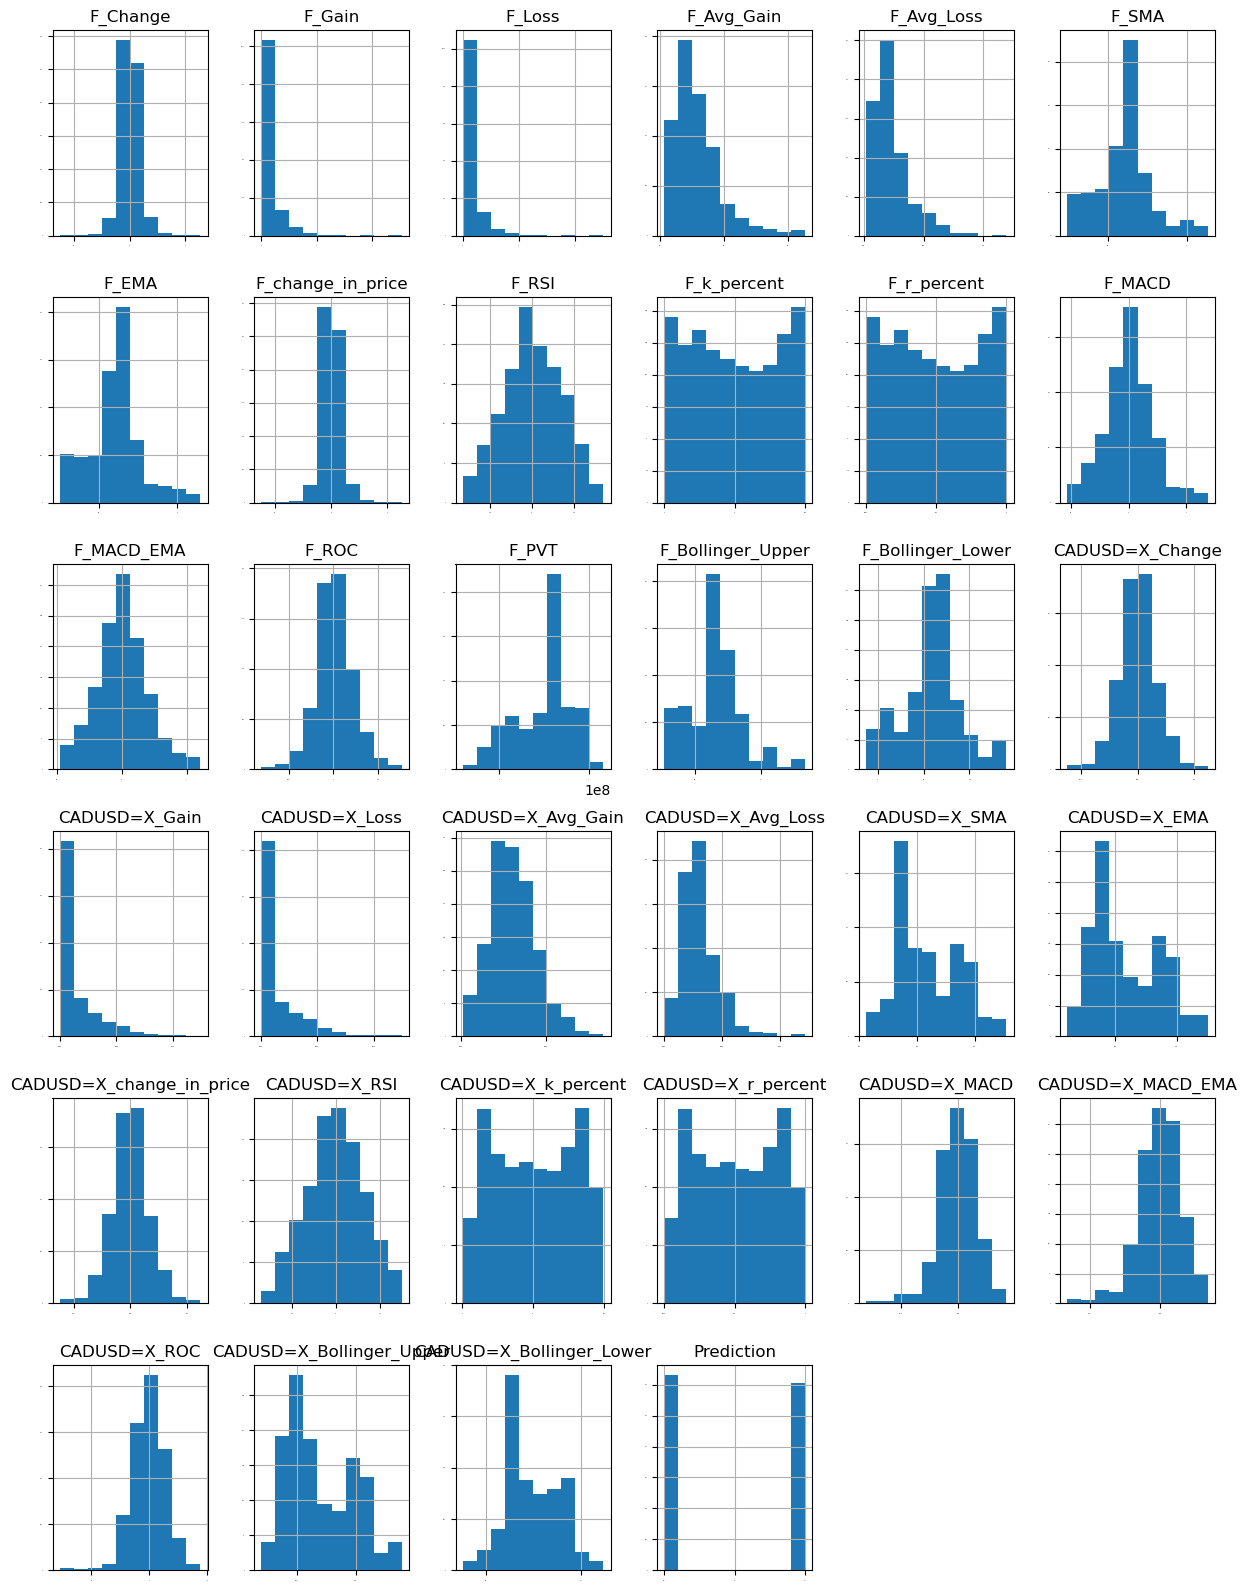

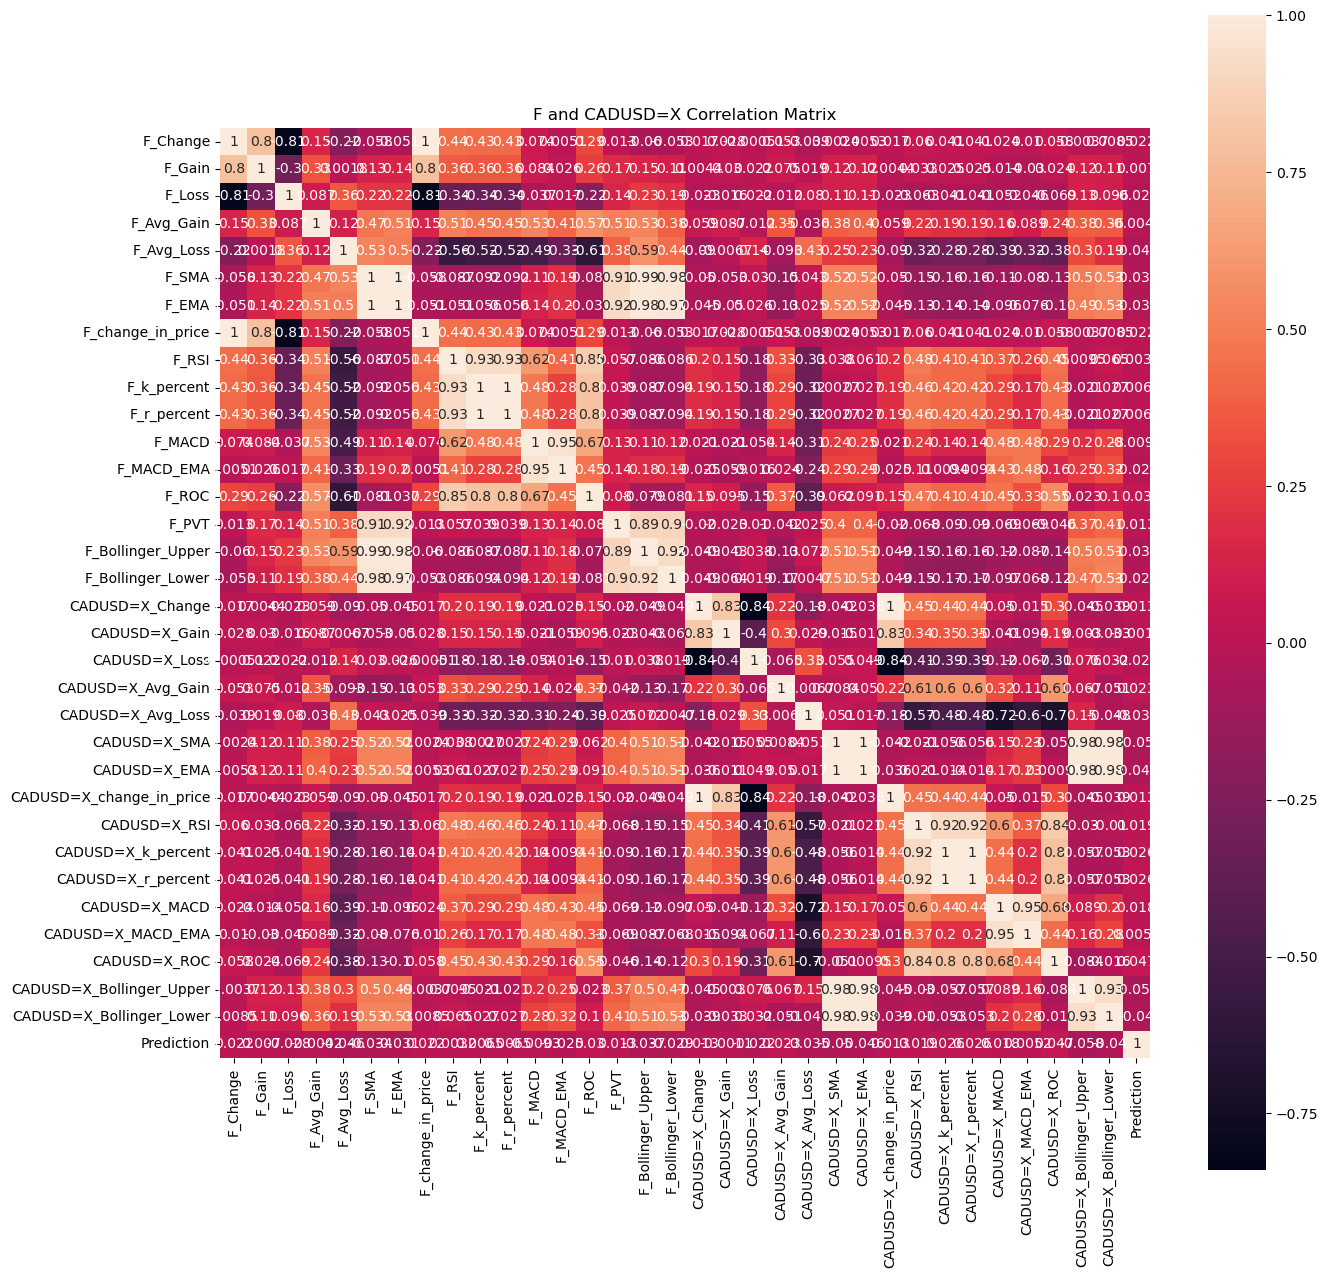

GM


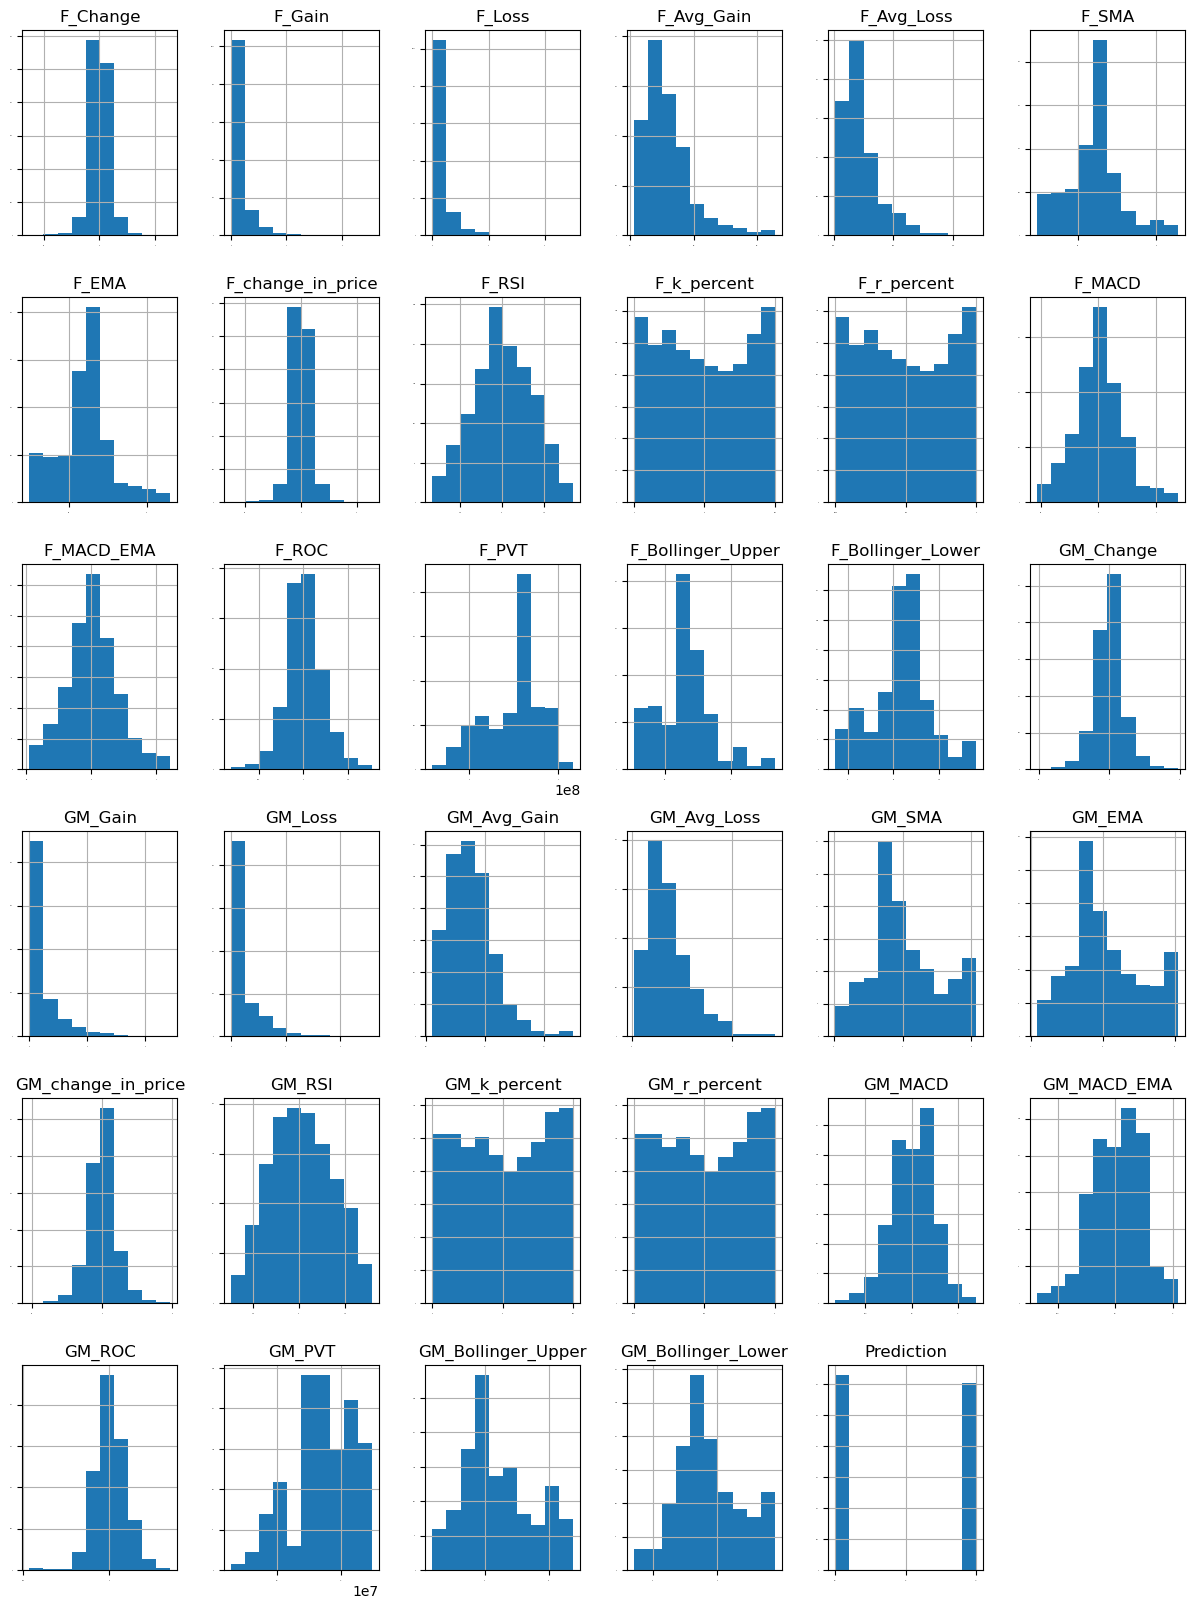

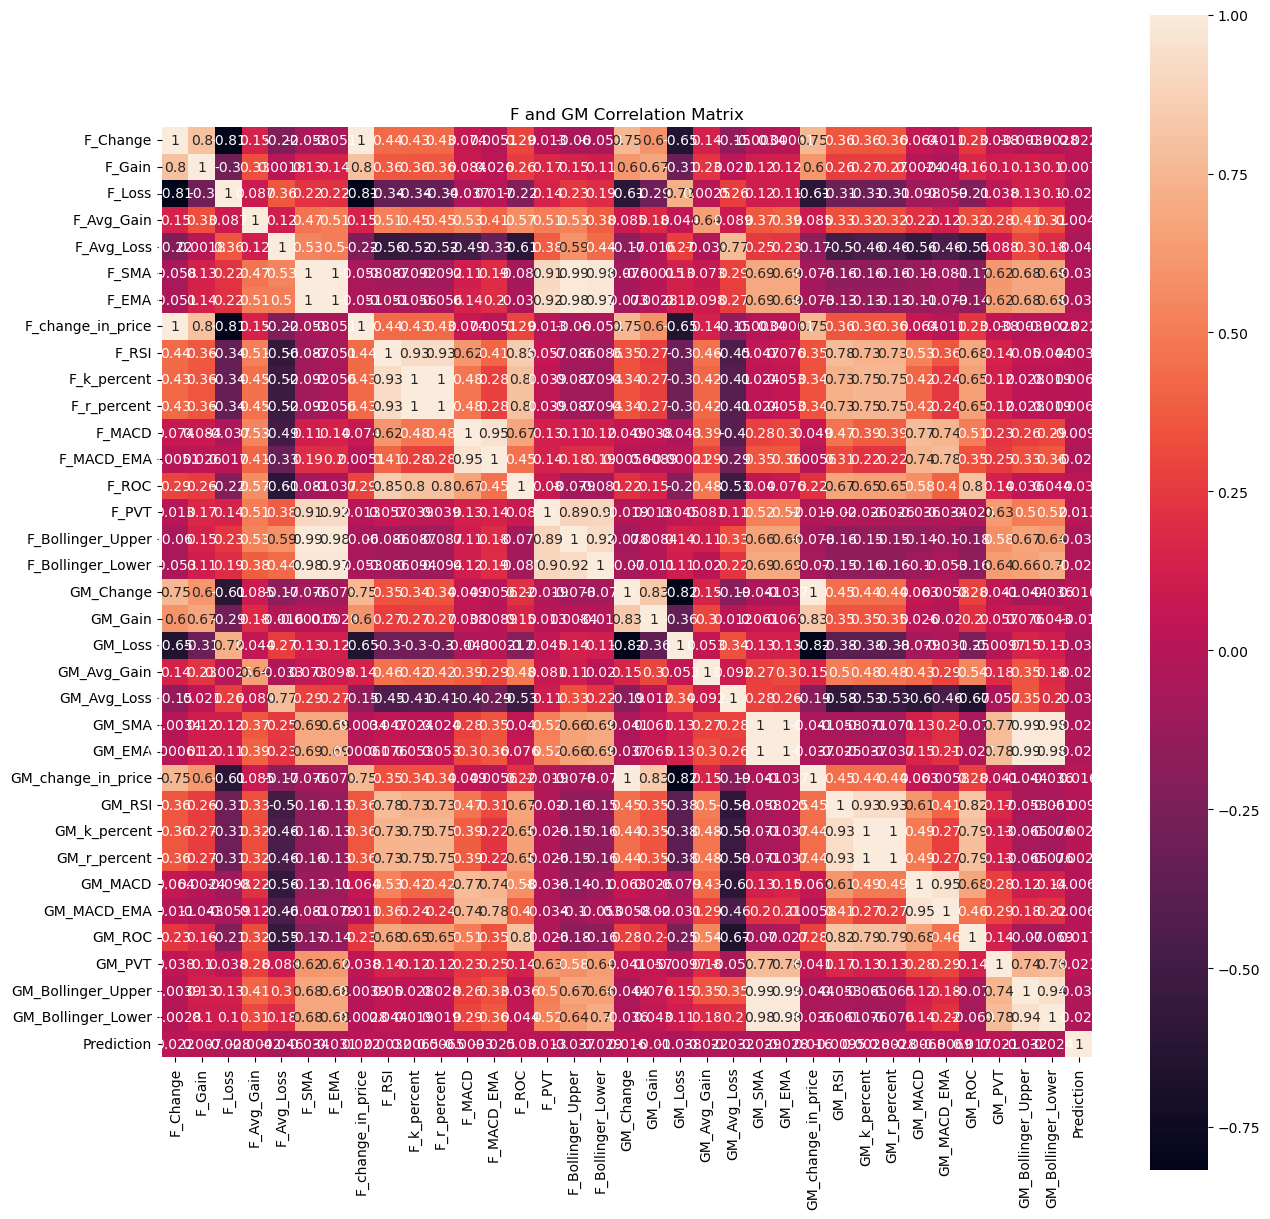

JCI


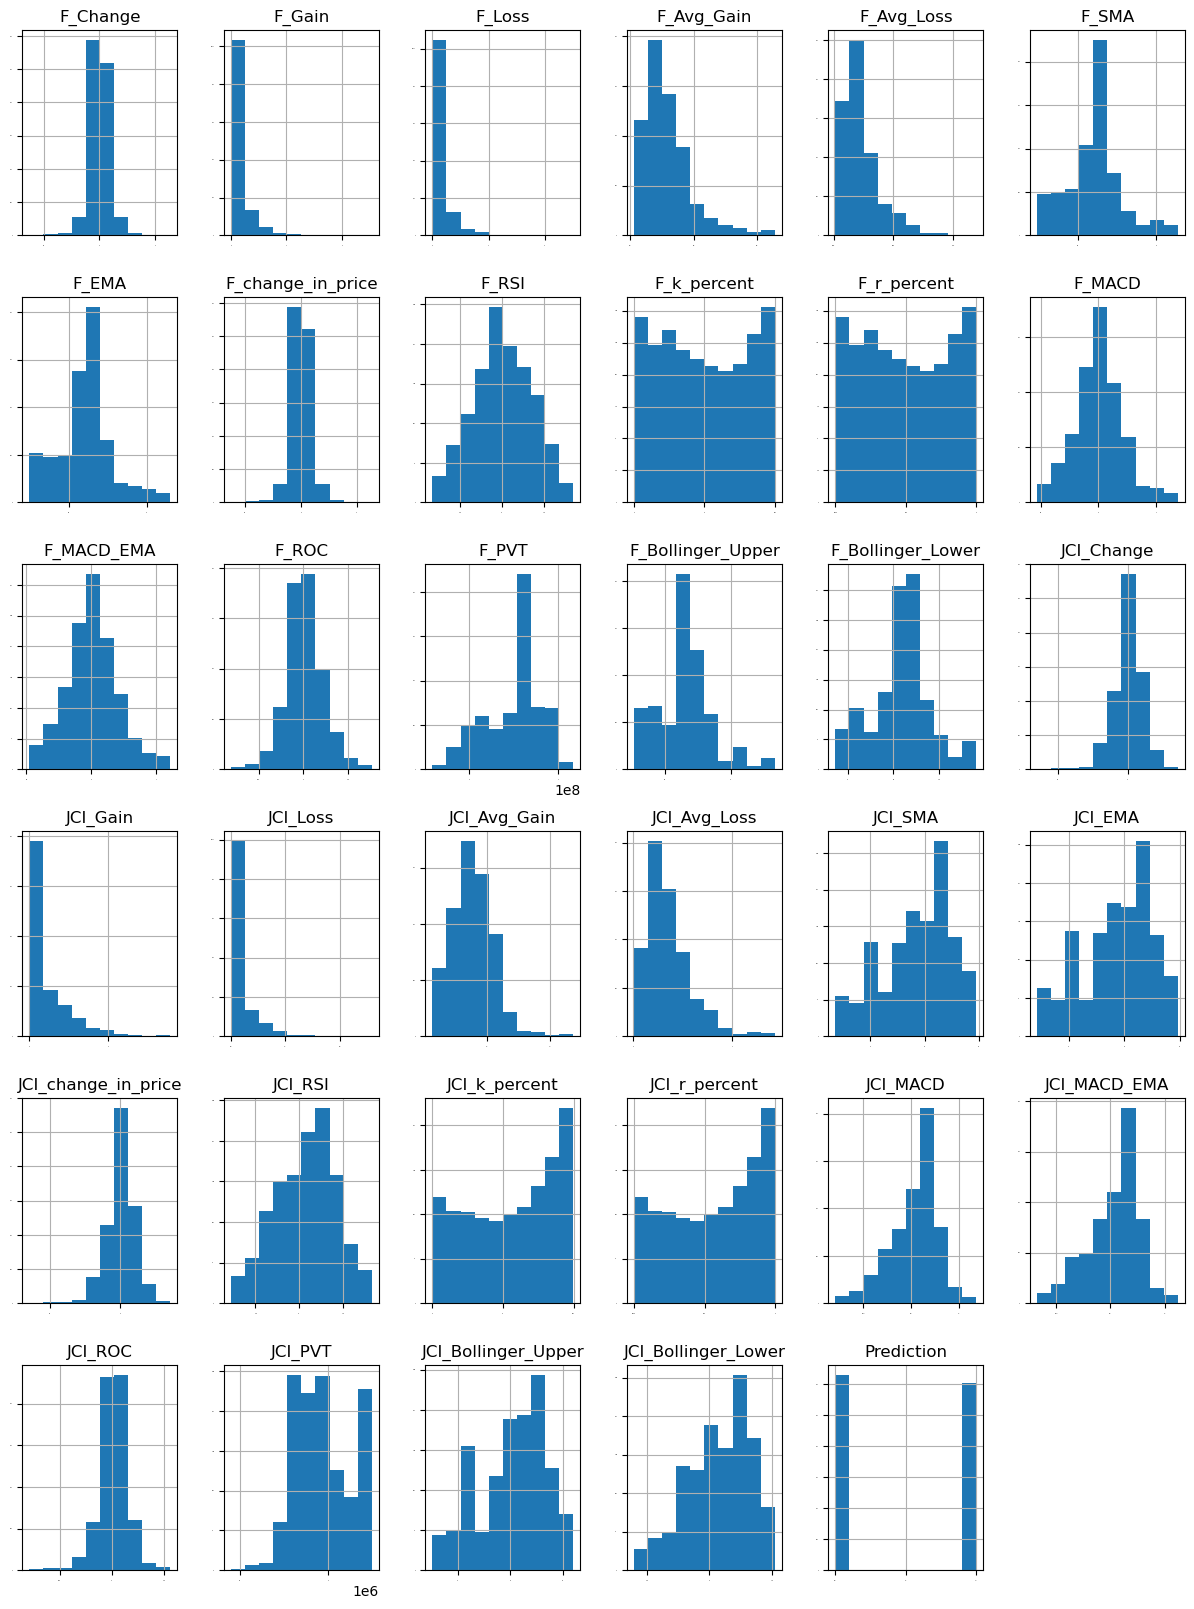

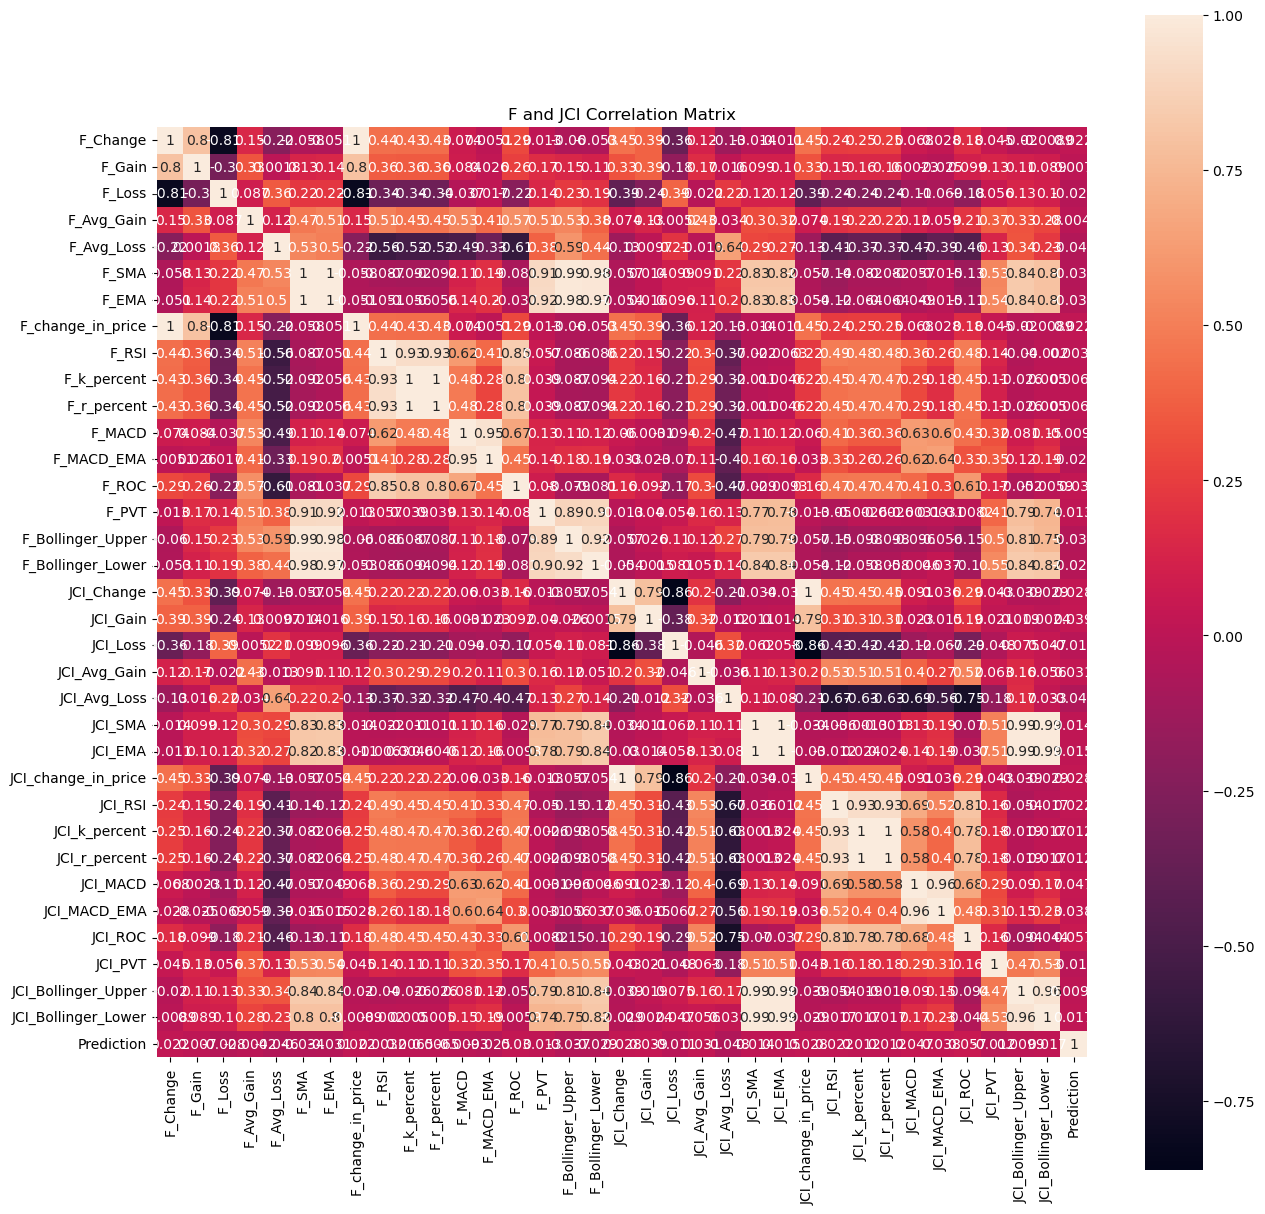

TM


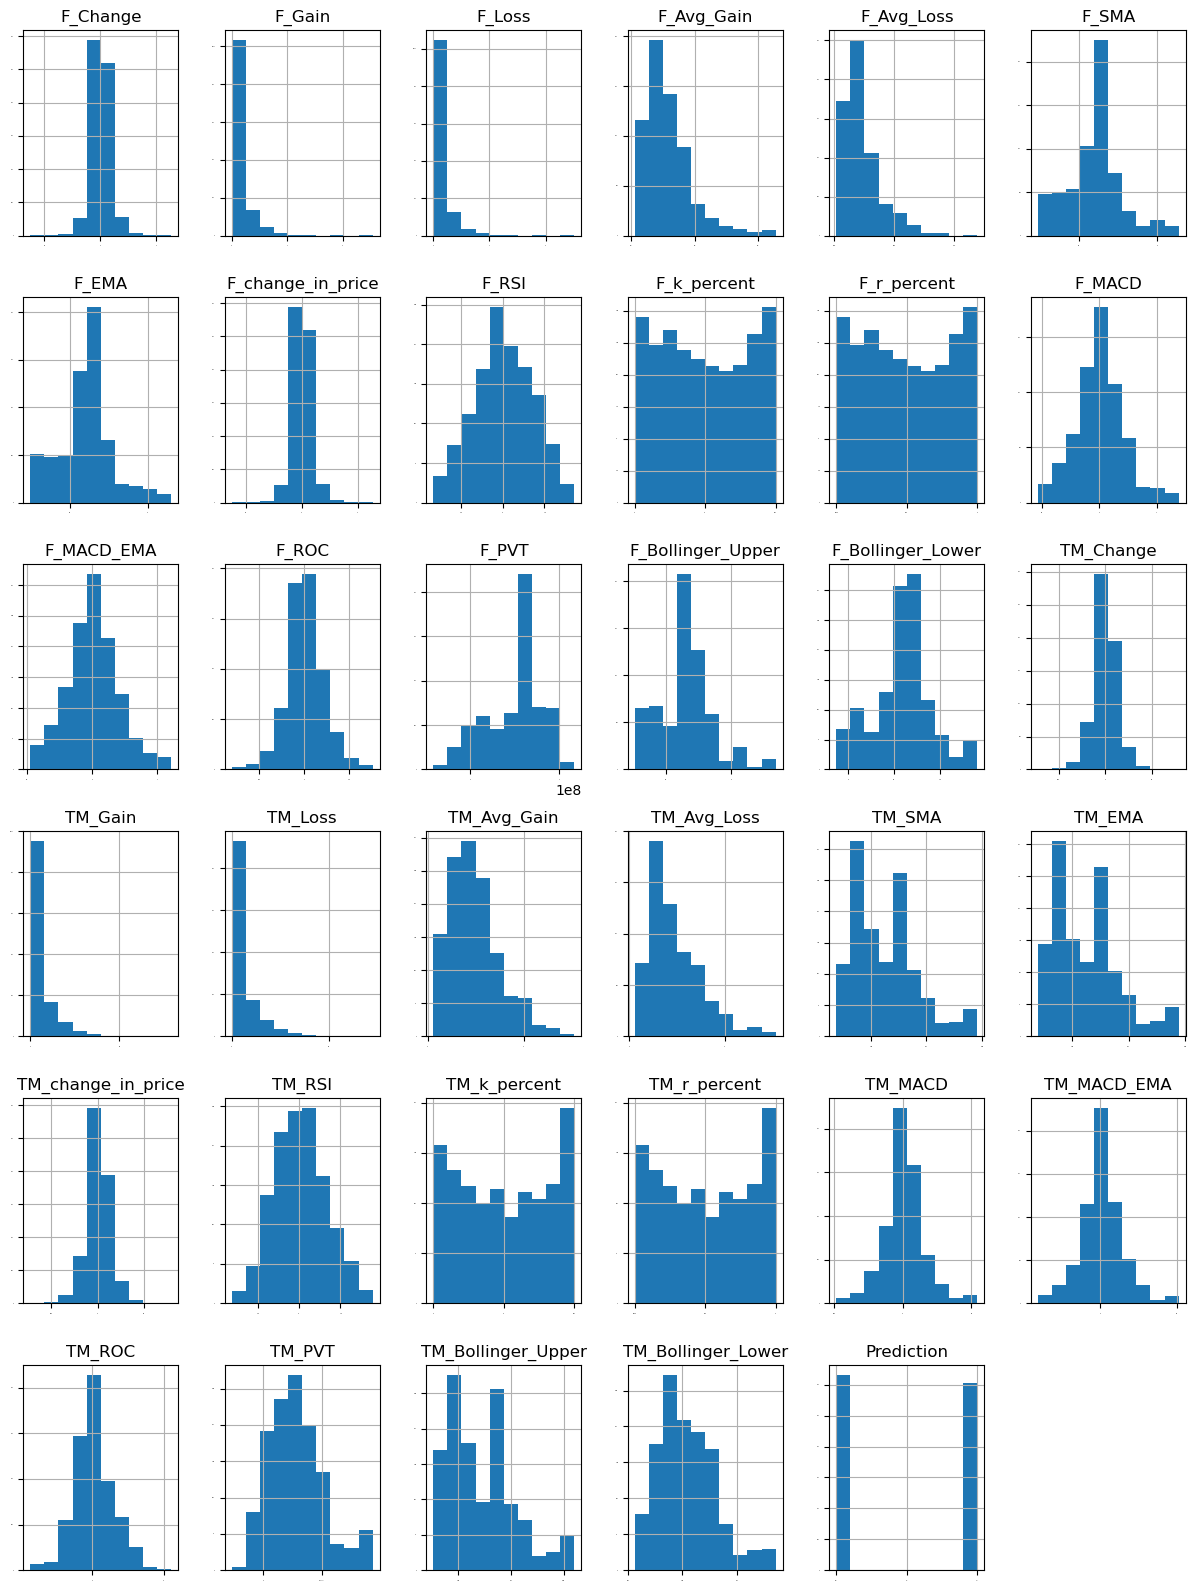

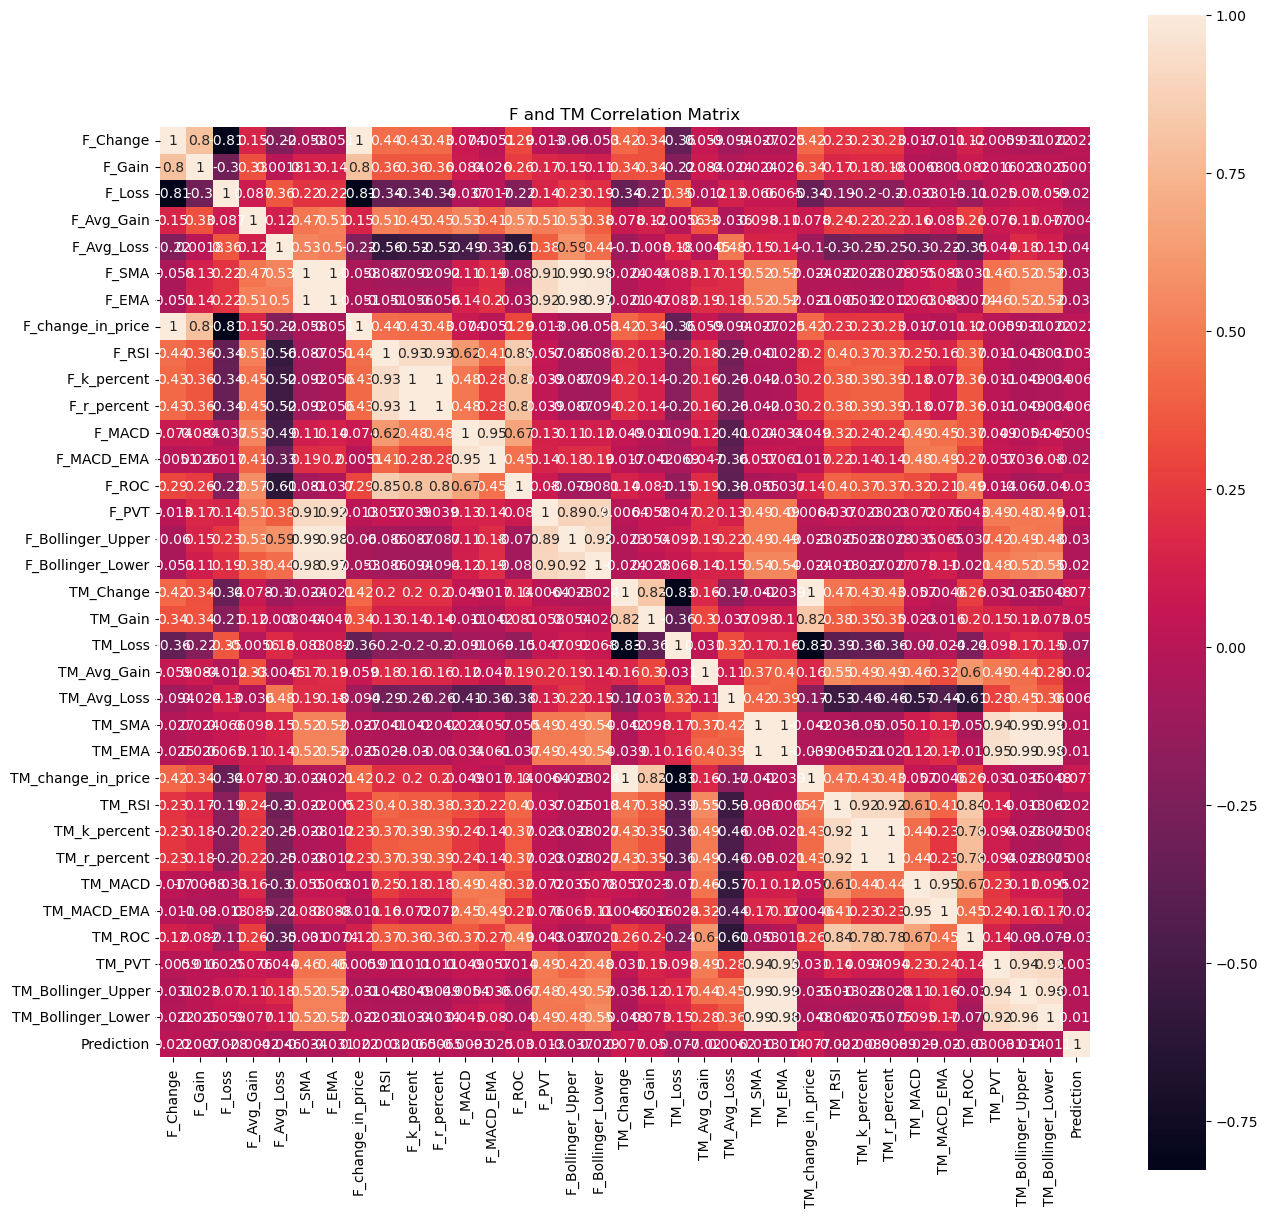

TRYUSD=X


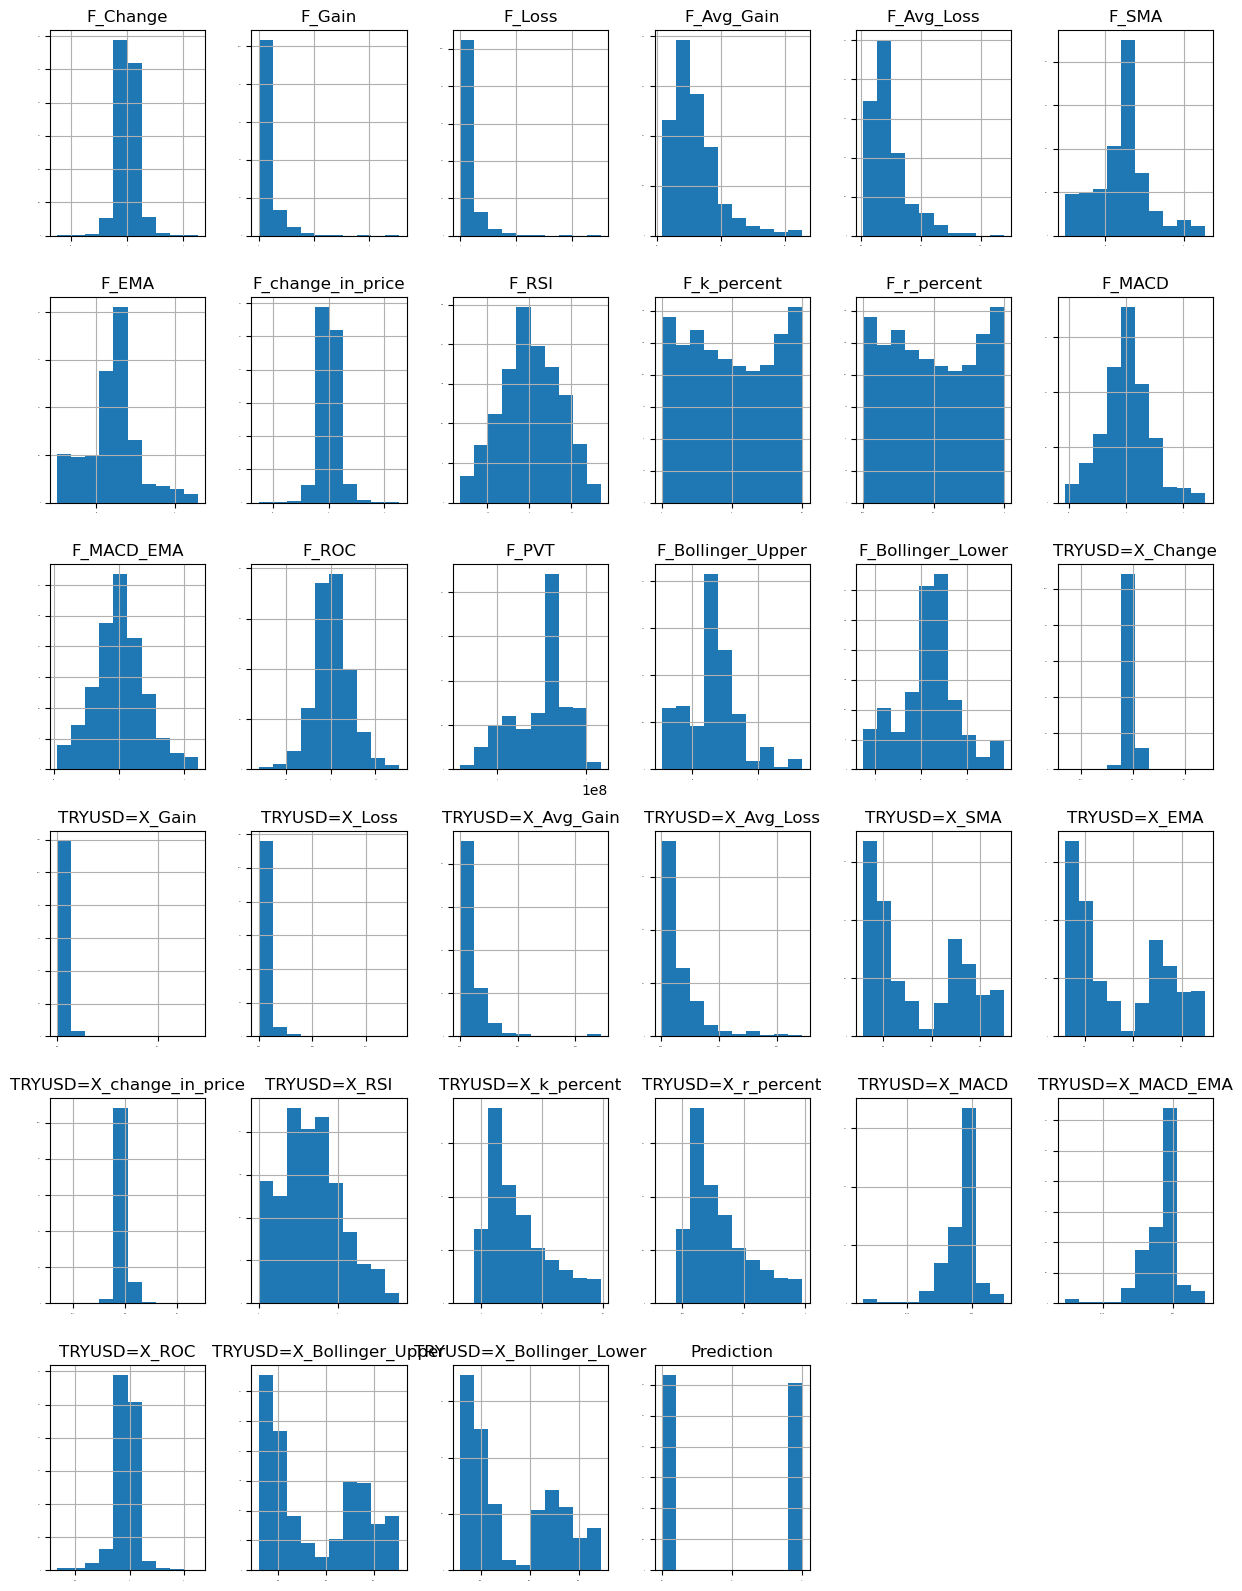

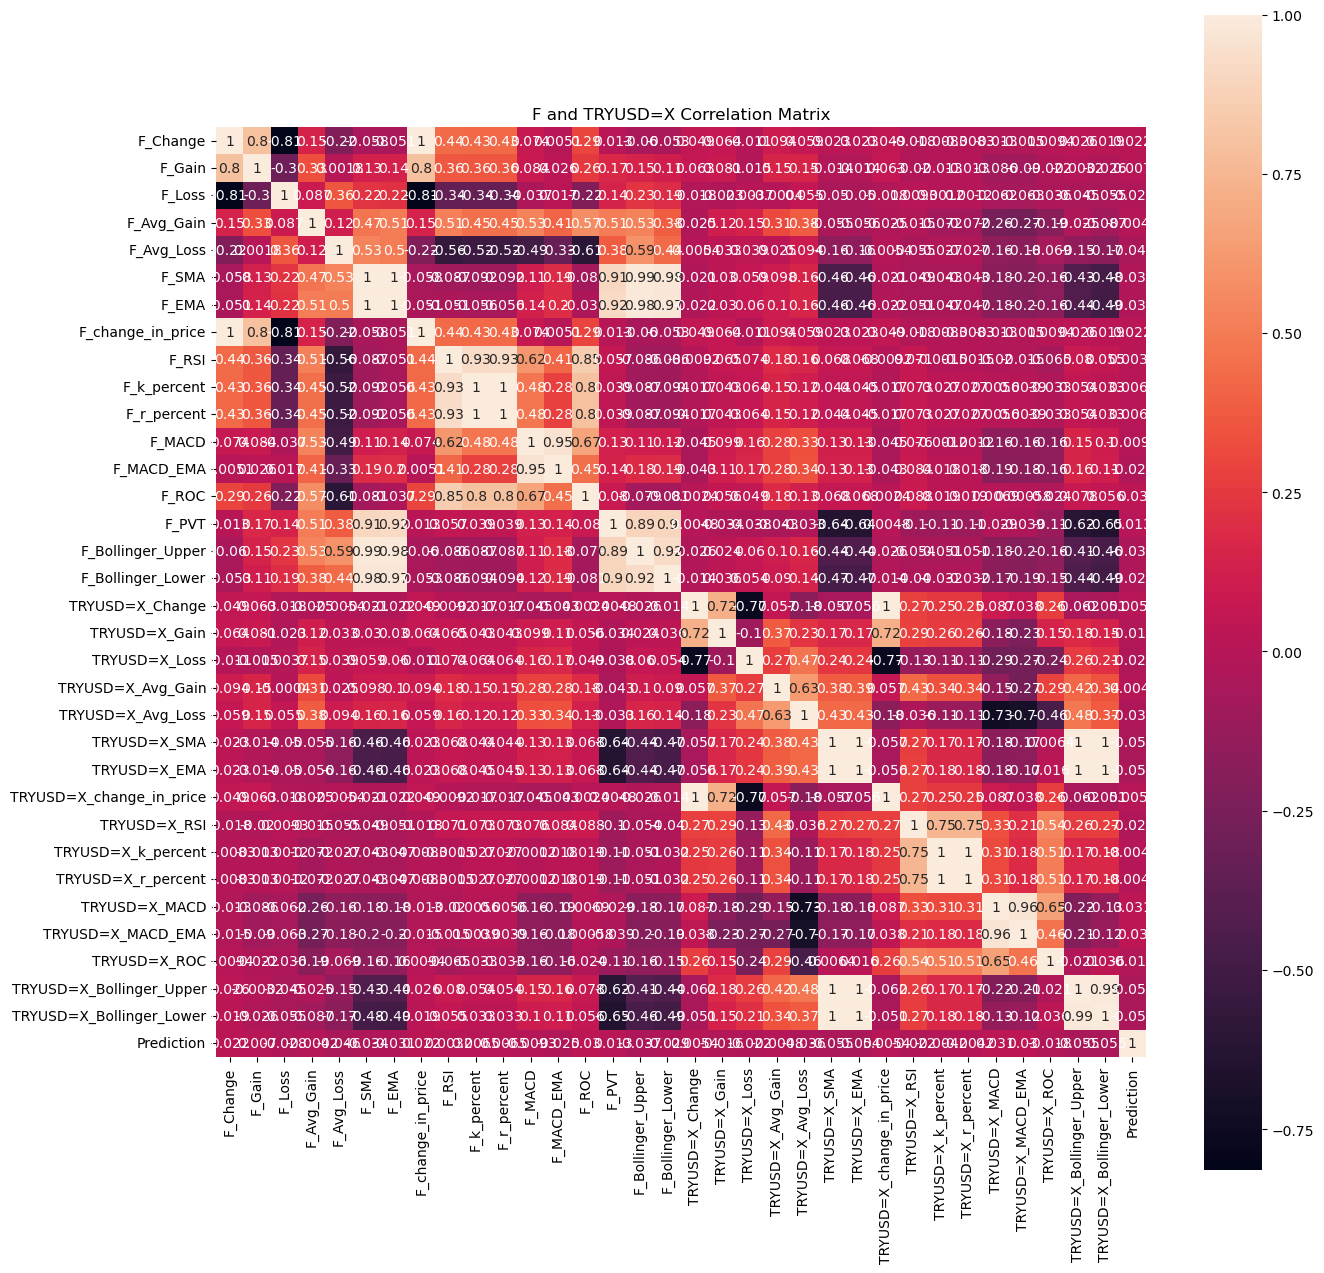

^IXIC


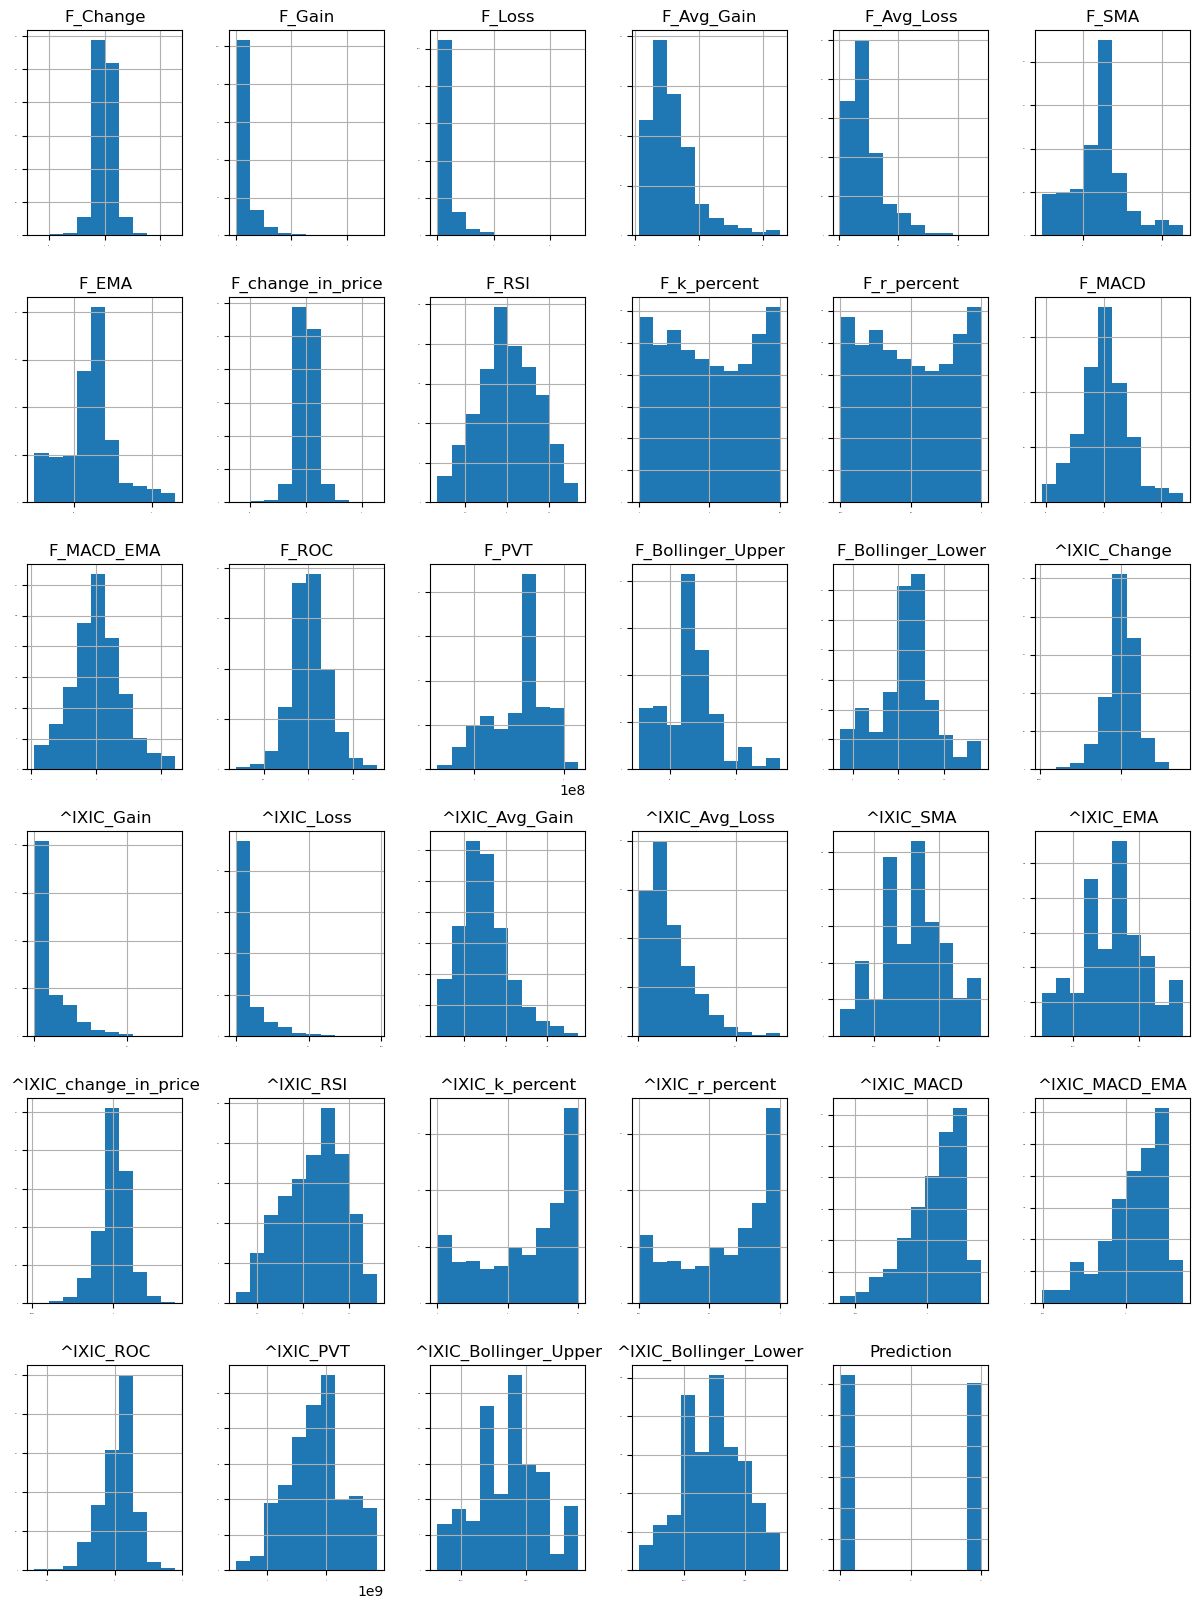

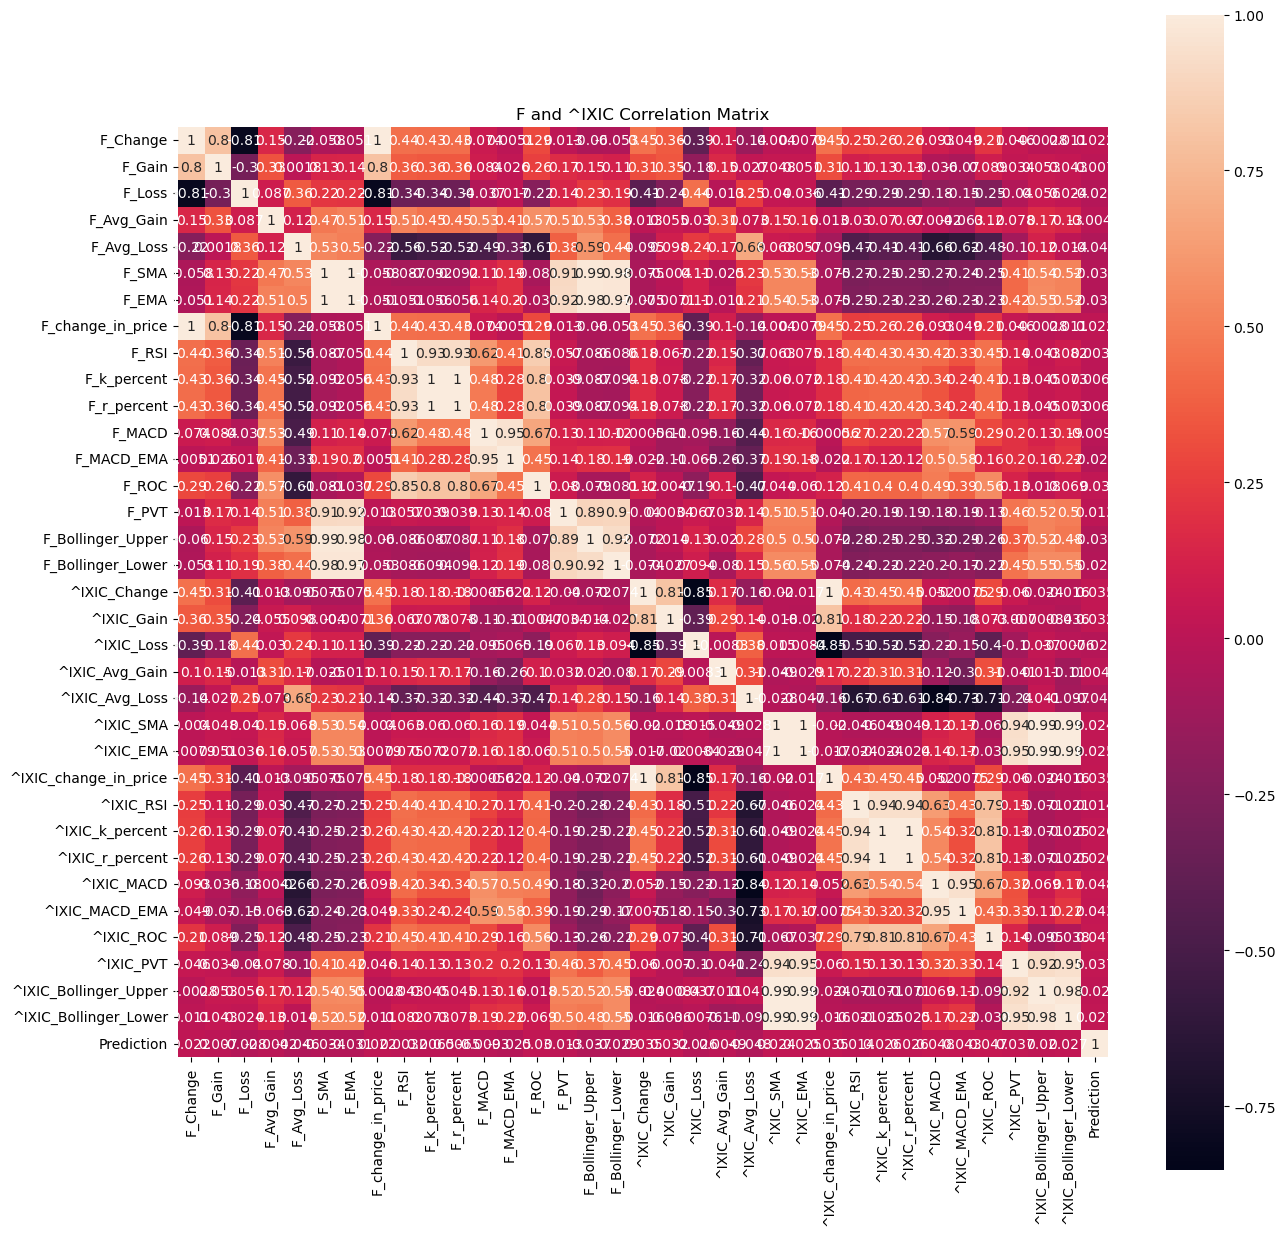

In [13]:
for t in tickers:
    print(t)
    df1 = extract_cols(df, t)
    df1.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(15,20))
    plt.show()

    correlation = df1.corr()
    plt.figure(figsize=(15,15))
    plt.title('F and ' + t + ' Correlation Matrix')
    sns.heatmap(correlation, vmax=1, square=True, annot=True)
    plt.show()

## Split train-test sets

In [14]:
df

Date  CADUSD=X_Change  CADUSD=X_Gain  \
0     2019-11-26 00:00:00+00:00        -0.000418       0.000000   
1     2019-11-27 00:00:00+00:00         0.001932       0.001932   
2     2019-11-29 00:00:00+00:00        -0.000607       0.000000   
3     2019-12-02 00:00:00+00:00        -0.000238       0.000000   
4     2019-12-03 00:00:00+00:00        -0.001081       0.000000   
...                         ...              ...            ...   
1232  2024-10-22 00:00:00+00:00        -0.001776       0.000000   
1233  2024-10-23 00:00:00+00:00         0.000905       0.000905   
1234  2024-10-24 00:00:00+00:00        -0.001072       0.000000   
1235  2024-10-25 00:00:00+00:00        -0.000866       0.000000   
1236  2024-10-28 00:00:00+00:00        -0.002197       0.000000   

      CADUSD=X_Loss  CADUSD=X_Avg_Gain  CADUSD=X_Avg_Loss  CADUSD=X_SMA  \
0          0.000418           0.000289           0.000910      0.756581   
1          0.000000           0.000427           0.000767      0.756063   
2          0.000607           0.000427           0.000641      0.755736   
3          0.000238           0.000419           0.000658      0.755404   
4          0.001081           0.000419           0.000707      0.754937   
...             ...                ...                ...           ...   
1232       0.001776           0.000308           0.001477      0.733303   
1233       0.000000           0.000245           0.001477      0.732536   
1234       0.001072           0.000245           0.001513      0.731416   
1235       0.000866           0.000245           0.001406      0.730423   
1236       0.002197           0.000245           0.001293      0.729302   

      CADUSD=X_EMA  CADUSD=X_change_in_price  CADUSD=X_RSI  ...      F_RSI  \
0         0.756180                 -0.000418     27.821853  ...  62.087549   
1         0.755938                  0.001932     42.880806  ...  67.610216   
2         0.755661                 -0.000607     39.864127  ...  62.910674   
3         0.755387                 -0.000238     38.634678  ...  57.178300   
4         0.755037                 -0.001081     33.260985  ...  45.657569   
...            ...                       ...           ...  ...        ...   
1232      0.730472                 -0.001776     22.129881  ...  63.192190   
1233      0.729835                  0.000905     28.290869  ...  59.825069   
1234      0.729157                 -0.001072     25.529720  ...  67.105734   
1235      0.728461                 -0.000866     23.401396  ...  56.038726   
1236      0.727622                 -0.002197     18.810221  ...  67.090123   

      F_k_percent  F_r_percent    F_MACD  F_MACD_EMA     F_ROC         F_PVT  \
0       73.913071   -26.086929  0.006892    0.002249 -0.331855  2.394865e+06   
1       89.583482   -10.416518  0.019164    0.005663  0.220269  2.768411e+06   
2       81.250149   -18.749851  0.025755    0.009711  0.221244  2.710846e+06   
3       70.833433   -29.166567  0.027163    0.013223  2.270145  2.505366e+06   
4       45.833433   -54.166567  0.019687    0.014522  1.137661  1.963927e+06   
...           ...          ...       ...         ...       ...           ...   
1232    91.764633    -8.235367  0.063288    0.007636  6.315788  6.779642e+07   
1233    80.219848   -19.780152  0.071755    0.020460  4.635769  6.762839e+07   
1234    98.850548    -1.149452  0.091931    0.034754  7.149667  6.835647e+07   
1235    72.631549   -27.368451  0.093129    0.046429  4.237286  6.776479e+07   
1236    97.894690    -2.105310  0.116938    0.060531  6.460670  7.041972e+07   

      F_Bollinger_Upper  F_Bollinger_Lower  Prediction  
0              9.188927           8.586074           1  
1              9.183159           8.647842           0  
2              9.165730           8.712270           0  
3              9.172619           8.717381           0  
4              9.166840           8.712161           1  
...                 ...                ...         ...  
1232          11.195281 

In [15]:
y = df['Prediction'].copy()
X = df.drop(['Date','Prediction'], axis = 1).copy()

X_train = X.iloc[:-5].copy()
y_train = y.iloc[:-5].copy()
X_test = X.iloc[-5:].copy()
y_test = y.iloc[-5:].copy()

In [16]:
y_test

1232    0
1233    1
1234    0
1235    1
1236    0
Name: Prediction, dtype: int64

In [17]:
# Number of trees in random forest
n_estimators = [20, 80, 100, 500] 
# Maximum number of levels in tree
max_depth = [5, 10, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ['gini', 'entropy'] 

# Create parameter grids
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'bootstrap': bootstrap,
    'criterion': criterion
}

In [18]:
# Define the RF model
model = RandomForestClassifier(random_state=0)
tscv = TimeSeriesSplit(n_splits=10)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)

# Fit the grid search object on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model and best hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model's performance on the test set
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Best Hyperparameters: {best_params}")
print(f"Test Set Accuracy: {acc:.4f}")

Best Hyperparameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}
Test Set Accuracy: 0.6000


In [19]:
#y_train

In [20]:
len(df)

1237

## Build random Forest Grid Search

In [21]:
# Number of trees in random forest
n_estimators = [20, 80, 100, 500] 
# Maximum number of levels in tree
max_depth = [5, 10, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ['gini', 'entropy'] 

# Create parameter grids
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'bootstrap': bootstrap,
    'criterion': criterion
}

In [22]:
def best_grid_search(rf, ticker: str, X_train, X_test, y_train, y_test):

    X_tr, X_t, y_tr, y_t = extract_train_test_set(X_train, X_test, y_train, y_test, ticker)
    
    # Scale X_train and X_test
    # scaler = StandardScaler()
    # scaled_X_train = scaler.fit_transform(X_tr)
    # scaled_X_test = scaler.fit_transform(X_t)

    tscv = TimeSeriesSplit(10, test_size=5)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)

                              
    # Fit the grid search to the data
    grid_result = grid_search.fit(X_tr, y_tr)
    best_grid = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    predictions = best_grid.predict(X_tr)
    train_accuracy = accuracy_score(y_tr, predictions)
    # predictions = best_grid.predict(X_t)
    # best_accuracy = accuracy_score(y_t, predictions)
    col = X_tr.columns

    return best_grid, best_params, grid_result.best_score_, col, predictions

## Base model

In [23]:
base_model = RandomForestClassifier(random_state=0)
base_grid, base_params, base_accuracy, col, base_prediction = best_grid_search(base_model, 'F', X_train, X_test, y_train, y_test)
print('Base model accuracy:', base_accuracy)

feature_names_base = col
importances_base = base_grid.feature_importances_

forest_importances_base = pd.Series(importances_base, index=feature_names_base)
      
fig, ax = plt.subplots(figsize=(12, 5))
forest_importances_base.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI - Base model")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

Best: 0.640000 using {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100}
Base model accuracy: 0.64


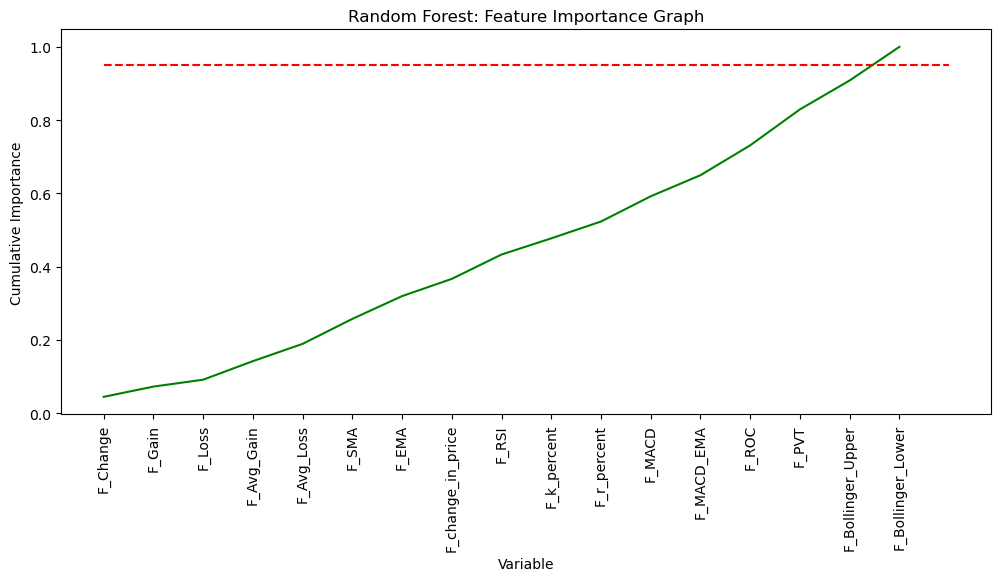

In [24]:
x_values = list(range(len(importances_base)))
cumulative_importances = np.cumsum(forest_importances_base.values)

plt.figure(figsize=(12,5))
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(forest_importances_base), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, forest_importances_base.index, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')
plt.show()

## Multiple tickers

CADUSD=X:
Best: 0.620000 using {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
Best Grid search model for F and CADUSD=X accuracy: 0.62
Improvement of -3.13%.


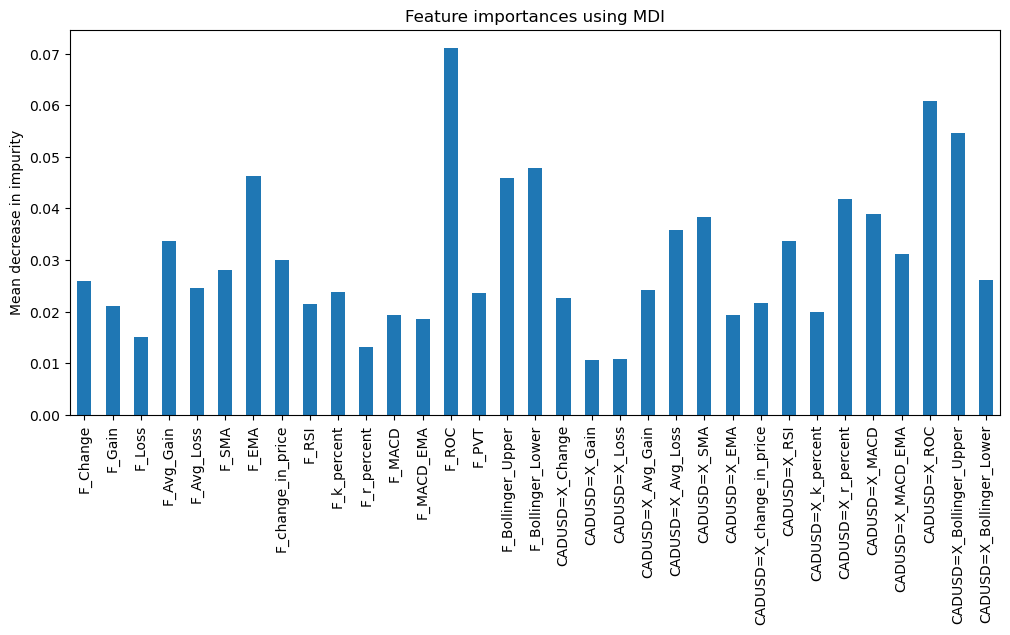

GM:
Best: 0.640000 using {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100}
Best Grid search model for F and GM accuracy: 0.64
Improvement of 0.00%.


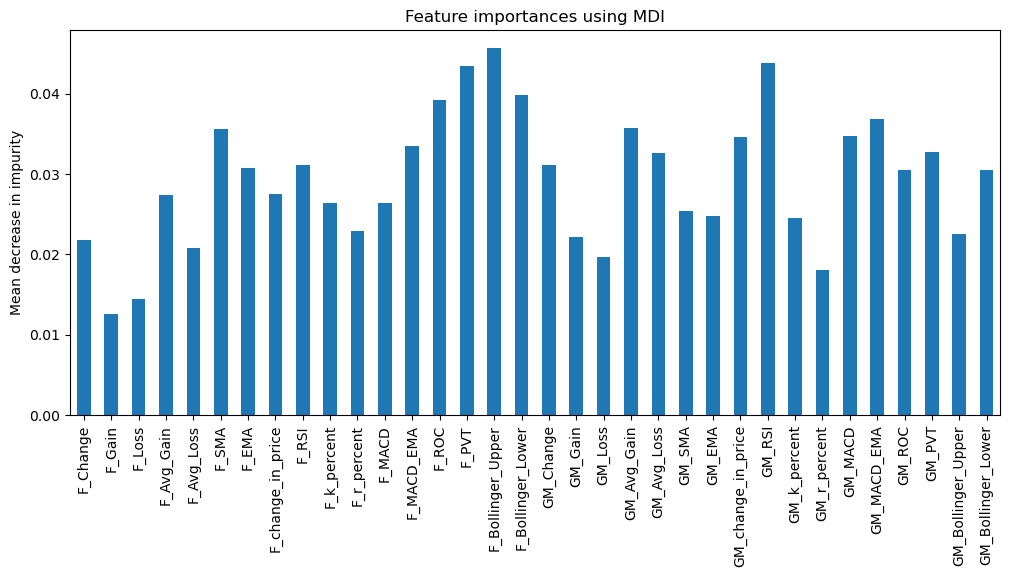

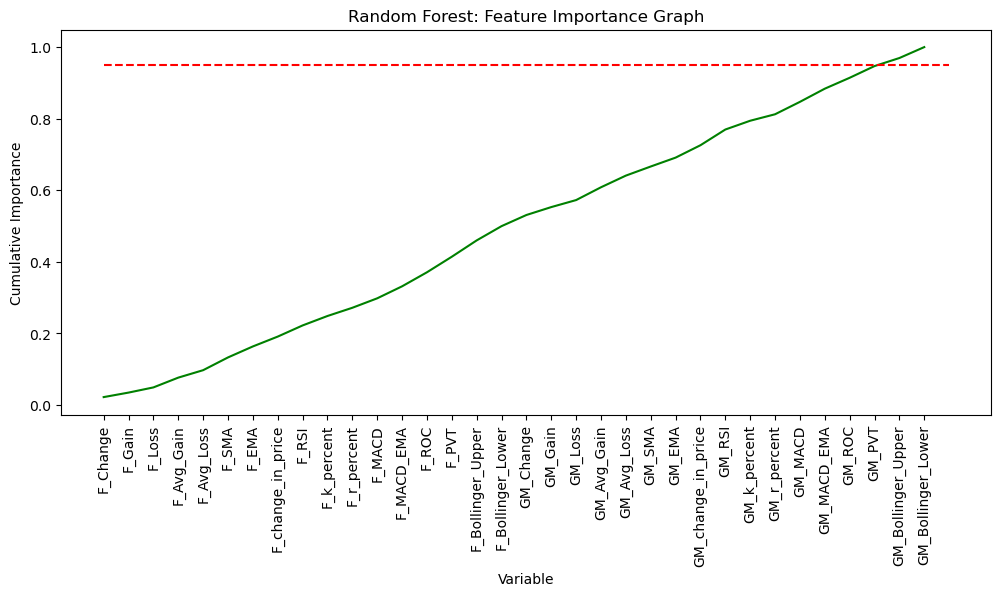

JCI:
Best: 0.660000 using {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
Best Grid search model for F and JCI accuracy: 0.66
Improvement of 3.13%.


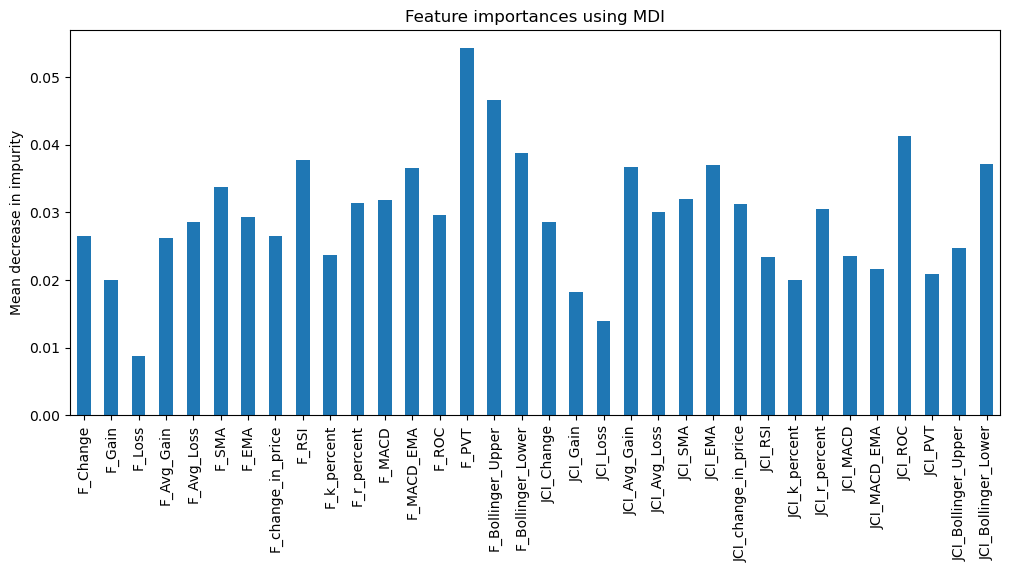

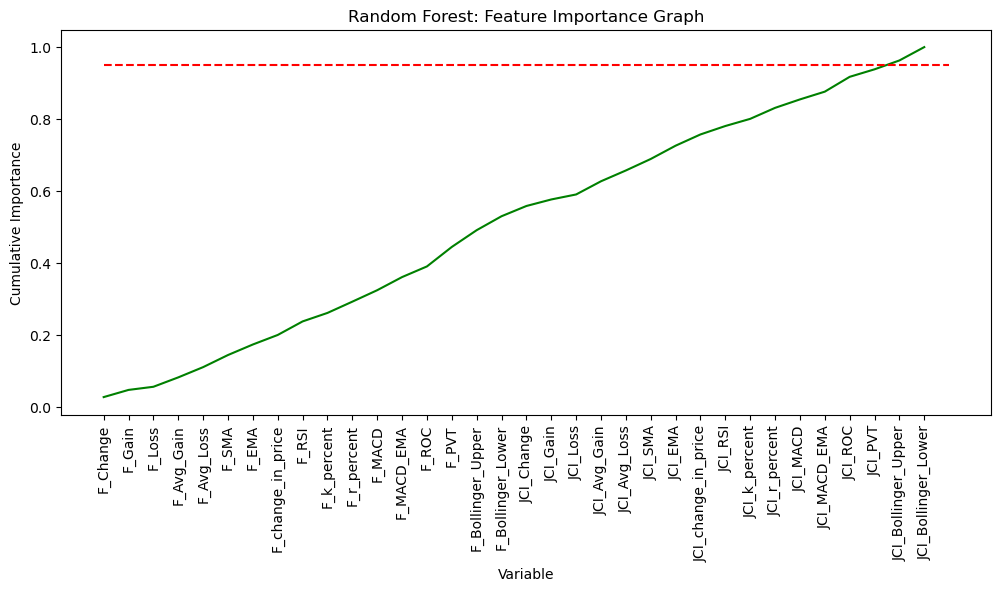

TM:
Best: 0.560000 using {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
Best Grid search model for F and TM accuracy: 0.5599999999999999
Improvement of -12.50%.


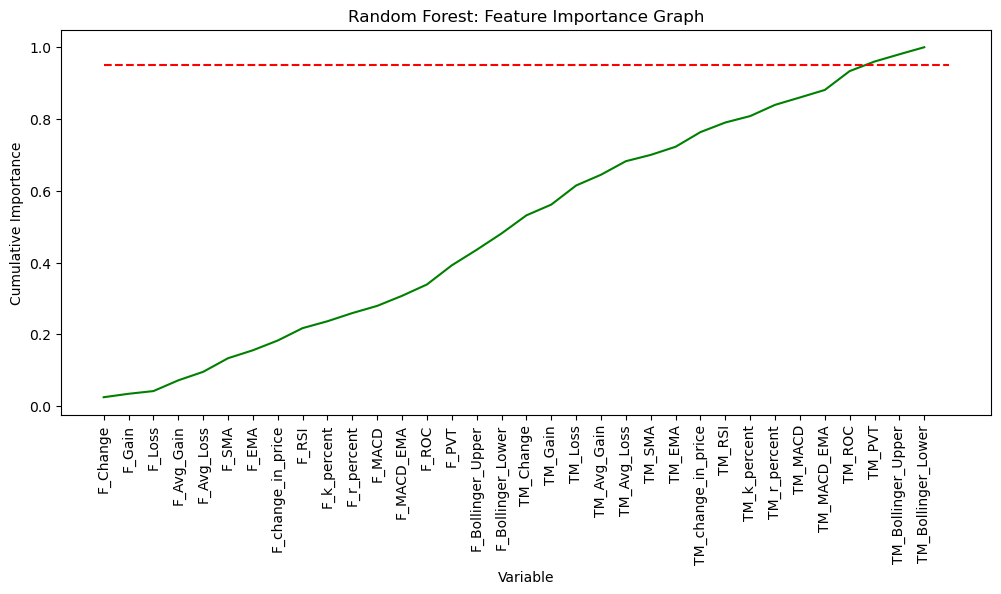

TRYUSD=X:
Best: 0.620000 using {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
Best Grid search model for F and TRYUSD=X accuracy: 0.6199999999999999
Improvement of -3.13%.


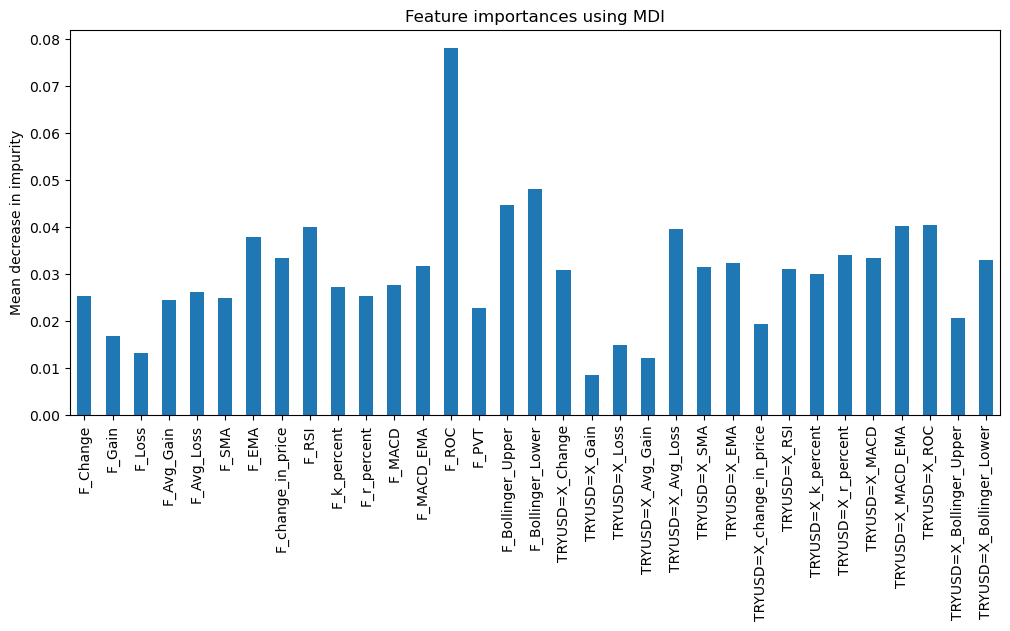

^IXIC:
Best: 0.640000 using {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'n_estimators': 500}
Best Grid search model for F and ^IXIC accuracy: 0.6399999999999999
Improvement of -0.00%.


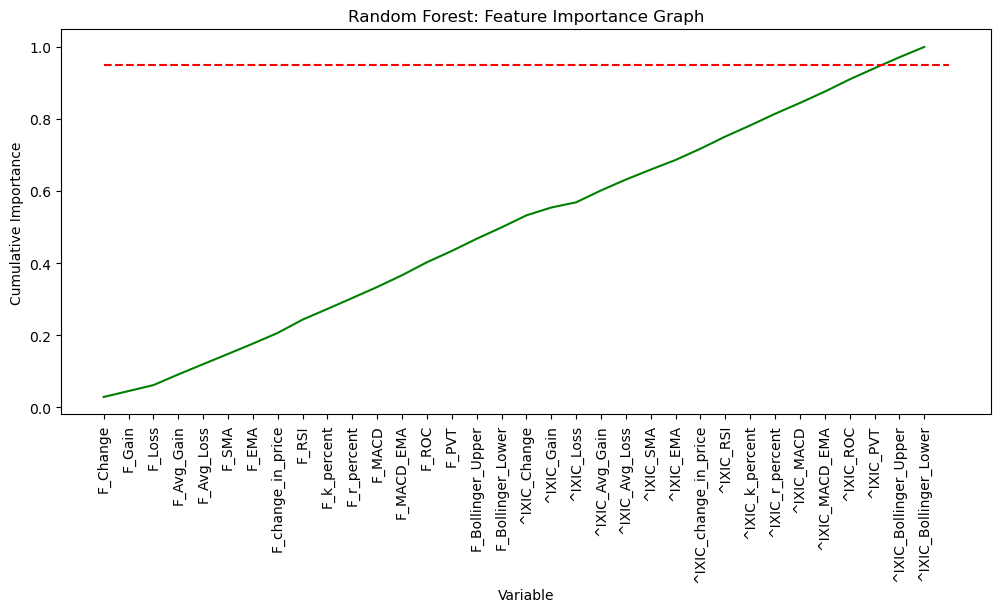

In [25]:
best_grid = {}
best_params = {}
best_accuracy = {}
improvement = {}
#cv_results = {}
cols = {}
prediction = {}

for t in tickers:
    # Create a random forest model
    rf = RandomForestClassifier(random_state=0)

    print(t + ':')
    
    best_grid[t], best_params[t], best_accuracy[t], cols[t], prediction[t] = best_grid_search(rf, t, X_train, X_test, y_train, y_test)
    #best_grid[t], best_params[t], cv_results[t], cols[t] = best_grid_search(rf, t, X_train, X_test, y_train, y_test)

    improvement[t] = 100 * (best_accuracy[t] - base_accuracy) / base_accuracy

    
    print('Best Grid search model for F and ' + t + ' accuracy:', best_accuracy[t]) 
    print('Improvement of {:0.2f}%.'.format(improvement[t]))

    feature_names = cols[t]
    importances = best_grid[t].feature_importances_

    forest_importances = pd.Series(importances, index=feature_names)
      
    fig, ax = plt.subplots(figsize=(12, 5))
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    plt.show()

    x_values = list(range(len(importances)))
    cumulative_importances = np.cumsum(forest_importances.values)

    plt.figure(figsize=(12,5))
    plt.plot(x_values, cumulative_importances, 'g-')
    # Draw line at 95% of importance retained
    plt.hlines(y = 0.95, xmin = 0, xmax = len(forest_importances), color = 'r', linestyles = 'dashed')
    # Format x ticks and labels
    plt.xticks(x_values, forest_importances.index, rotation = 'vertical')
    # Axis labels and title
    plt.xlabel('Variable')
    plt.ylabel('Cumulative Importance')
    plt.title('Random Forest: Feature Importance Graph')
    plt.show()

In [26]:
best_grid['CADUSD=X'].feature_importances_

array([0.0259111 , 0.02118382, 0.01499964, 0.03365256, 0.02450094,
       0.02803093, 0.04624625, 0.02994632, 0.02151894, 0.02388558,
       0.01320949, 0.01932888, 0.01862716, 0.07105297, 0.02361454,
       0.04596781, 0.04786012, 0.02261067, 0.01060451, 0.01088769,
       0.0241918 , 0.03582055, 0.03835411, 0.01931548, 0.02166376,
       0.03363878, 0.01994032, 0.04174603, 0.03887506, 0.03121891,
       0.06083516, 0.05464934, 0.02611077])

In [27]:
best_grid['Base'] = base_grid
best_accuracy['Base'] = base_accuracy
best_params['Base'] = base_params
prediction['Base'] = base_prediction
cols['Base'] = 'Base'

In [28]:
best_params

{'CADUSD=X': {'bootstrap': True,
  'criterion': 'gini',
  'max_depth': 5,
  'n_estimators': 20},
 'GM': {'bootstrap': True,
  'criterion': 'entropy',
  'max_depth': 5,
  'n_estimators': 100},
 'JCI': {'bootstrap': True,
  'criterion': 'gini',
  'max_depth': 5,
  'n_estimators': 80},
 'TM': {'bootstrap': True,
  'criterion': 'gini',
  'max_depth': 5,
  'n_estimators': 80},
 'TRYUSD=X': {'bootstrap': True,
  'criterion': 'gini',
  'max_depth': 5,
  'n_estimators': 20},
 '^IXIC': {'bootstrap': True,
  'criterion': 'gini',
  'max_depth': 20,
  'n_estimators': 500},
 'Base': {'bootstrap': True,
  'criterion': 'entropy',
  'max_depth': 5,
  'n_estimators': 100}}

## Compare different ticker marks

In [29]:
c = ['Ticker', 'n_estimators', 'max_depth', 'bootstrap', 'criterion', 'accuracy', 'improvement']
RF = pd.DataFrame(columns=c)

In [30]:
RF

Empty DataFrame
Columns: [Ticker, n_estimators, max_depth, bootstrap, criterion, accuracy, improvement]
Index: []

In [31]:
tickers.append('Base')
tickers

['CADUSD=X', 'GM', 'JCI', 'TM', 'TRYUSD=X', '^IXIC', 'Base']

In [32]:
for i, t in enumerate(tickers):
    RF.loc[i, 'Ticker'] = t

In [33]:
for i, t in enumerate(tickers):
    for j, c in enumerate(RF.columns[1:5]):
        RF.iloc[i, j + 1] = best_params[t][c]
    RF.loc[i, 'accuracy'] = best_accuracy[t]
    RF.loc[i, 'improvement'] = 100 * (best_accuracy[t] - base_accuracy) / base_accuracy

In [34]:
RF

Ticker n_estimators max_depth bootstrap criterion accuracy improvement
0  CADUSD=X           20         5      True      gini     0.62      -3.125
1        GM          100         5      True   entropy     0.64         0.0
2       JCI           80         5      True      gini     0.66       3.125
3        TM           80         5      True      gini     0.56       -12.5
4  TRYUSD=X           20         5      True      gini     0.62      -3.125
5     ^IXIC          500        20      True      gini     0.64        -0.0
6      Base          100         5      True   entropy     0.64         0.0

## Retrain the best model on entire training set

In [35]:
models = {}
for i, t in enumerate(tickers):
    X_tr, X_t, y_tr, y_t = extract_train_test_set(X_train, X_test, y_train, y_test, t)
    models[t] = best_grid[t]
    models[t].fit(X_tr, y_tr)
    print(t)
    print('Training accuracy: %f', accuracy_score(models[t].predict(X_tr), y_tr))
    print('Testing accuracy: %f', accuracy_score(models[t].predict(X_t), y_t))
    print('-------------------')

CADUSD=X
Training accuracy: %f 0.752435064935065
Testing accuracy: %f 0.4
-------------------
GM
Training accuracy: %f 0.752435064935065
Testing accuracy: %f 0.2
-------------------
JCI
Training accuracy: %f 0.788961038961039
Testing accuracy: %f 0.4
-------------------
TM
Training accuracy: %f 0.7621753246753247
Testing accuracy: %f 0.4
-------------------
TRYUSD=X
Training accuracy: %f 0.7402597402597403
Testing accuracy: %f 0.2
-------------------
^IXIC
Training accuracy: %f 1.0
Testing accuracy: %f 0.4
-------------------
Base
Training accuracy: %f 0.739448051948052
Testing accuracy: %f 0.4
-------------------


## Backtesting

In [36]:
size = len(df) // 10
rng = np.random.RandomState(443)
forecast_length = 5
for j in range(10):
    m = rng.randint(j*size + forecast_length, (j + 1)*size - forecast_length)
    print(m)

30
240
349
392
540
715
786
882
1039
1119


In [37]:
df

Date  CADUSD=X_Change  CADUSD=X_Gain  \
0     2019-11-26 00:00:00+00:00        -0.000418       0.000000   
1     2019-11-27 00:00:00+00:00         0.001932       0.001932   
2     2019-11-29 00:00:00+00:00        -0.000607       0.000000   
3     2019-12-02 00:00:00+00:00        -0.000238       0.000000   
4     2019-12-03 00:00:00+00:00        -0.001081       0.000000   
...                         ...              ...            ...   
1232  2024-10-22 00:00:00+00:00        -0.001776       0.000000   
1233  2024-10-23 00:00:00+00:00         0.000905       0.000905   
1234  2024-10-24 00:00:00+00:00        -0.001072       0.000000   
1235  2024-10-25 00:00:00+00:00        -0.000866       0.000000   
1236  2024-10-28 00:00:00+00:00        -0.002197       0.000000   

      CADUSD=X_Loss  CADUSD=X_Avg_Gain  CADUSD=X_Avg_Loss  CADUSD=X_SMA  \
0          0.000418           0.000289           0.000910      0.756581   
1          0.000000           0.000427           0.000767      0.756063   
2          0.000607           0.000427           0.000641      0.755736   
3          0.000238           0.000419           0.000658      0.755404   
4          0.001081           0.000419           0.000707      0.754937   
...             ...                ...                ...           ...   
1232       0.001776           0.000308           0.001477      0.733303   
1233       0.000000           0.000245           0.001477      0.732536   
1234       0.001072           0.000245           0.001513      0.731416   
1235       0.000866           0.000245           0.001406      0.730423   
1236       0.002197           0.000245           0.001293      0.729302   

      CADUSD=X_EMA  CADUSD=X_change_in_price  CADUSD=X_RSI  ...      F_RSI  \
0         0.756180                 -0.000418     27.821853  ...  62.087549   
1         0.755938                  0.001932     42.880806  ...  67.610216   
2         0.755661                 -0.000607     39.864127  ...  62.910674   
3         0.755387                 -0.000238     38.634678  ...  57.178300   
4         0.755037                 -0.001081     33.260985  ...  45.657569   
...            ...                       ...           ...  ...        ...   
1232      0.730472                 -0.001776     22.129881  ...  63.192190   
1233      0.729835                  0.000905     28.290869  ...  59.825069   
1234      0.729157                 -0.001072     25.529720  ...  67.105734   
1235      0.728461                 -0.000866     23.401396  ...  56.038726   
1236      0.727622                 -0.002197     18.810221  ...  67.090123   

      F_k_percent  F_r_percent    F_MACD  F_MACD_EMA     F_ROC         F_PVT  \
0       73.913071   -26.086929  0.006892    0.002249 -0.331855  2.394865e+06   
1       89.583482   -10.416518  0.019164    0.005663  0.220269  2.768411e+06   
2       81.250149   -18.749851  0.025755    0.009711  0.221244  2.710846e+06   
3       70.833433   -29.166567  0.027163    0.013223  2.270145  2.505366e+06   
4       45.833433   -54.166567  0.019687    0.014522  1.137661  1.963927e+06   
...           ...          ...       ...         ...       ...           ...   
1232    91.764633    -8.235367  0.063288    0.007636  6.315788  6.779642e+07   
1233    80.219848   -19.780152  0.071755    0.020460  4.635769  6.762839e+07   
1234    98.850548    -1.149452  0.091931    0.034754  7.149667  6.835647e+07   
1235    72.631549   -27.368451  0.093129    0.046429  4.237286  6.776479e+07   
1236    97.894690    -2.105310  0.116938    0.060531  6.460670  7.041972e+07   

      F_Bollinger_Upper  F_Bollinger_Lower  Prediction  
0              9.188927           8.586074           1  
1              9.183159           8.647842           0  
2              9.165730           8.712270           0  
3              9.172619           8.717381           0  
4              9.166840           8.712161           1  
...                 ...                ...         ...  
1232          11.195281 

In [38]:
def backtest(forecast_length=5):
    size = len(df) // 10
    rng = np.random.RandomState(45)
    acc_backtest = {}

    for t in best_grid:
        if t == 'Base':
            backtest = extract_cols(df, 'F')
        else:
            backtest = extract_cols(df, t)
        acc_backtest[t] = []
        y_backtest = backtest['Prediction'].copy()
        X_backtest = backtest.drop(['Prediction'], axis = 1).copy()
        model = models[t]
        for j in range(10):
            m = rng.randint(j*size + forecast_length, (j + 1)*size - forecast_length)
            y_b = y_backtest[m: m + forecast_length]
            X_b = X_backtest[m: m + forecast_length]
            acc_backtest[t].append(accuracy_score(model.predict(X_b), y_b))


    return acc_backtest

In [39]:
backtest(2)

{'CADUSD=X': [1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0],
 'GM': [1.0, 1.0, 1.0, 0.5, 1.0, 0.5, 0.5, 1.0, 0.5, 1.0],
 'JCI': [1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0],
 'TM': [0.5, 1.0, 1.0, 1.0, 0.5, 0.0, 0.5, 1.0, 1.0, 1.0],
 'TRYUSD=X': [0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0],
 '^IXIC': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'Base': [0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]}

In [40]:
acc_backtest_1 = backtest(1)
acc_backtest_2 = backtest(2)
acc_backtest_3 = backtest(3)
acc_backtest_4 = backtest(4)
acc_backtest_5 = backtest(5)

In [41]:
acc_backtest_1

{'CADUSD=X': [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0],
 'GM': [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'JCI': [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0],
 'TM': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0],
 'TRYUSD=X': [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 '^IXIC': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'Base': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

In [42]:
acc_backtest_5

{'CADUSD=X': [1.0, 0.8, 0.6, 0.8, 1.0, 0.6, 0.8, 0.2, 0.4, 0.8],
 'GM': [0.8, 0.8, 0.6, 0.6, 1.0, 1.0, 0.2, 0.6, 0.8, 1.0],
 'JCI': [1.0, 0.6, 0.8, 1.0, 0.6, 0.8, 0.8, 0.6, 1.0, 1.0],
 'TM': [1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.6, 1.0, 0.8, 0.8],
 'TRYUSD=X': [1.0, 1.0, 0.4, 0.8, 1.0, 1.0, 0.6, 0.8, 0.8, 0.6],
 '^IXIC': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'Base': [0.8, 1.0, 0.6, 0.6, 0.8, 1.0, 0.6, 0.4, 0.8, 0.4]}

In [43]:
c = ['Ticker']
for i in range(1, 6):
    s = 'n = ' + str(i)
    c.append(s)

acc_backtest_mean = pd.DataFrame(columns=c)

for i, t in enumerate(best_grid):
    acc_backtest_mean.loc[i, 'Ticker'] = t
    
acc_backtest_mean
acc_backtest_std = acc_backtest_mean.copy()

In [44]:
acc_backtest_mean

Ticker n = 1 n = 2 n = 3 n = 4 n = 5
0  CADUSD=X   NaN   NaN   NaN   NaN   NaN
1        GM   NaN   NaN   NaN   NaN   NaN
2       JCI   NaN   NaN   NaN   NaN   NaN
3        TM   NaN   NaN   NaN   NaN   NaN
4  TRYUSD=X   NaN   NaN   NaN   NaN   NaN
5     ^IXIC   NaN   NaN   NaN   NaN   NaN
6      Base   NaN   NaN   NaN   NaN   NaN

In [45]:
for i, t in enumerate(acc_backtest_1):
    acc_backtest_mean.loc[i, 'n = 1'] = np.mean(acc_backtest_1[t])
    acc_backtest_mean.loc[i, 'n = 2'] = np.mean(acc_backtest_2[t])
    acc_backtest_mean.loc[i, 'n = 3'] = np.mean(acc_backtest_3[t])
    acc_backtest_mean.loc[i, 'n = 4'] = np.mean(acc_backtest_4[t])
    acc_backtest_mean.loc[i, 'n = 5'] = np.mean(acc_backtest_5[t])

    acc_backtest_std.loc[i, 'n = 1'] = np.std(acc_backtest_1[t])/np.sqrt(10)
    acc_backtest_std.loc[i, 'n = 2'] = np.std(acc_backtest_2[t])/np.sqrt(10)
    acc_backtest_std.loc[i, 'n = 3'] = np.std(acc_backtest_3[t])/np.sqrt(10)
    acc_backtest_std.loc[i, 'n = 4'] = np.std(acc_backtest_4[t])/np.sqrt(10)
    acc_backtest_std.loc[i, 'n = 5'] = np.std(acc_backtest_5[t])/np.sqrt(10)

In [46]:
acc_backtest_mean

Ticker n = 1 n = 2     n = 3  n = 4 n = 5
0  CADUSD=X   0.8   0.9       0.6   0.55   0.7
1        GM   0.9   0.8  0.833333  0.725  0.74
2       JCI   0.8  0.85  0.866667  0.775  0.82
3        TM   0.9  0.75  0.766667  0.825   0.9
4  TRYUSD=X   0.8   0.7       0.7  0.725   0.8
5     ^IXIC   1.0   1.0       1.0    1.0   1.0
6      Base   1.0   0.8       0.7    0.7   0.7

In [47]:
acc_backtest_std

Ticker     n = 1     n = 2     n = 3     n = 4     n = 5
0  CADUSD=X  0.126491  0.063246  0.091894  0.092195  0.076158
1        GM  0.094868   0.07746  0.070711   0.06567    0.0751
2       JCI  0.126491  0.072457   0.05164  0.074582  0.052536
3        TM  0.094868  0.106066  0.048305  0.061745  0.042426
4  TRYUSD=X  0.126491   0.07746   0.08756   0.06567  0.063246
5     ^IXIC       0.0       0.0       0.0       0.0       0.0
6      Base       0.0   0.07746  0.073786  0.059161  0.064807

## ROC for backtest

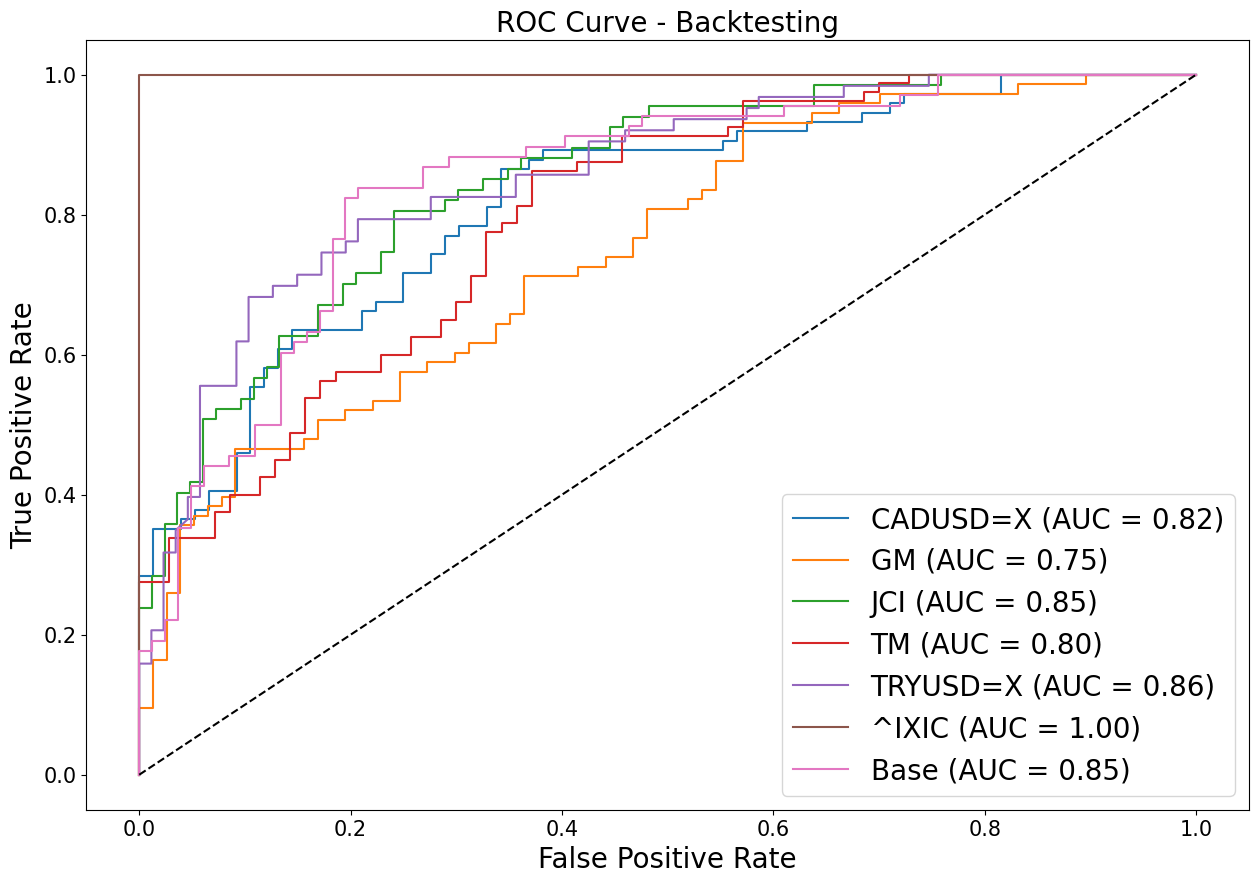

In [48]:
size = len(df) // 10
rng = np.random.RandomState(45)
forecast_length = 1

plt.figure(figsize=(15, 10))
for t in best_grid:
    if t == 'Base':
        backtest = extract_cols(df, 'F')
    else:
        backtest = extract_cols(df, t)
    

    y_backtest = backtest['Prediction'].copy()
    X_backtest = backtest.drop(['Prediction'], axis = 1).copy()
    X_b = pd.DataFrame()
    y_b = pd.DataFrame()

    for forecast_length in range(1, 6):
        for j in range(10):
            m = rng.randint(j*size + forecast_length, (j + 1)*size - forecast_length)
            y_b = pd.concat([y_b, y_backtest[m: m + forecast_length]])
            X_b = pd.concat([X_b, X_backtest[m: m + forecast_length]])

    model = models[t]

    y_pred_proba = model.predict_proba(X_b)[:, 1]
    fpr, tpr, _ = roc_curve(y_b, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{t} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve - Backtesting', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right', fontsize=20)
#plt.show()
plt.savefig('ROC_backtesting.jpg')

## Plot accuracy of backtest

In [49]:
x = [i + 1 for i in range(5)]
mean_df = acc_backtest_mean.drop('Ticker', axis=1).copy()
std_df = acc_backtest_std.drop('Ticker', axis=1).copy()

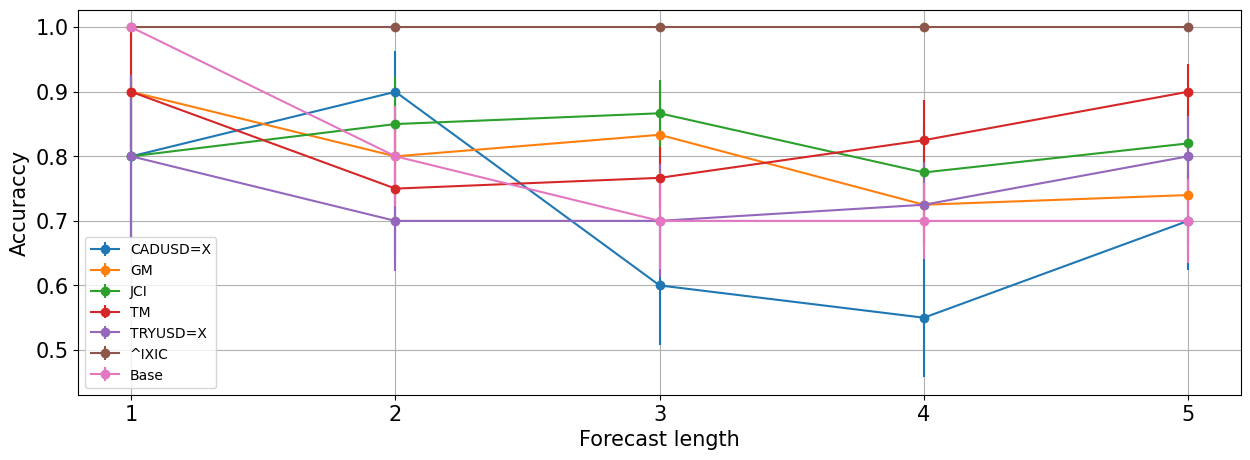

In [50]:
x = [i + 1 for i in range(5)]

plt.figure(figsize=(15,5))
for i in range(len(mean_df)):
    t = acc_backtest_mean.loc[i, 'Ticker']
    m = mean_df.iloc[i].to_numpy()
    s = std_df.iloc[i].to_numpy()
    plt.errorbar(x, m, s, marker='o', label=t)
plt.legend()
plt.xticks(x, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Forecast length',fontsize=15)
plt.ylabel('Accuraccy', fontsize=15)
plt.grid(True)
plt.show()

In [51]:
acc_backtest_1_df = pd.DataFrame(acc_backtest_1)
acc_backtest_1_df

CADUSD=X   GM  JCI   TM  TRYUSD=X  ^IXIC  Base
0       1.0  1.0  1.0  1.0       0.0    1.0   1.0
1       1.0  0.0  1.0  1.0       1.0    1.0   1.0
2       0.0  1.0  1.0  1.0       1.0    1.0   1.0
3       1.0  1.0  1.0  1.0       0.0    1.0   1.0
4       1.0  1.0  1.0  1.0       1.0    1.0   1.0
5       0.0  1.0  0.0  1.0       1.0    1.0   1.0
6       1.0  1.0  1.0  0.0       1.0    1.0   1.0
7       1.0  1.0  1.0  1.0       1.0    1.0   1.0
8       1.0  1.0  0.0  1.0       1.0    1.0   1.0
9       1.0  1.0  1.0  1.0       1.0    1.0   1.0

## Forward validation

### Import from Yahoo Finance

In [52]:
start = '2024-8-8'
end = '2024-11-30'

In [53]:
Ford = yf.download('F', start=start, end=end)
CADUSD = yf.download('CADUSD=X', start=start, end=end)
GM = yf.download('GM', start=start, end=end)
JCI = yf.download('JCI', start=start, end=end)
TM = yf.download('TM', start=start, end=end)
TRYUSD = yf.download('TRYUSD=X', start=start, end=end)
IXIC = yf.download('^IXIC', start=start, end=end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [54]:
Ford = Ford.reset_index()
CADUSD = CADUSD.reset_index()
GM = GM.reset_index()
JCI = JCI.reset_index()
TM = TM.reset_index()
TRYUSD = TRYUSD.reset_index()
IXIC = IXIC.reset_index()

In [55]:
tickers

['CADUSD=X', 'GM', 'JCI', 'TM', 'TRYUSD=X', '^IXIC', 'Base']

In [56]:
def indicators(df, ticker):
    t = ticker
    # Gain, Loss, Avg_Gain, and Avg_Loss
    df[t + '_Change'] = df['Close'].diff()
    df[t + '_Gain'] = df[t + '_Change'].apply(lambda x: x if x > 0 else 0)
    df[t + '_Loss'] = df[t + '_Change'].apply(lambda x: -x if x < 0 else 0)
    df[t + '_Avg_Gain'] = df[t + '_Gain'].rolling(window=14).mean()
    df[t + '_Avg_Loss'] = df[t + '_Loss'].rolling(window=14).mean()

    # Simple Moving Average (SMA)
    df[t + '_SMA'] = df['Close'].rolling(window=20).mean()

    # Exponential Moving Average (EMA)
    df[t + '_EMA'] = df['Close'].ewm(span=20, adjust=False).mean()

    # Relative Strength Index (RSI)
    df[t + '_change_in_price'] = df['Close'].diff()
    up_df, down_df = df[[t + '_change_in_price']].copy(), df[[t + '_change_in_price']].copy()
    up_df.loc[(up_df[t + '_change_in_price'] < 0), t + '_change_in_price'] = 0
    down_df.loc[(down_df[t + '_change_in_price'] > 0), t + '_change_in_price'] = 0
    down_df[t + '_change_in_price'] = down_df[t + '_change_in_price'].abs()
    ewma_up = up_df[t + '_change_in_price'].ewm(span=14).mean()
    ewma_down = down_df[t + '_change_in_price'].ewm(span=14).mean()
    relative_strength = ewma_up / ewma_down
    df[t + '_RSI'] = 100.0 - (100.0 / (1.0 + relative_strength))

    # Stochastic Oscillator
    low_14 = df['Low'].rolling(window=14).min()
    high_14 = df['High'].rolling(window=14).max()
    df[t + '_k_percent'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))

    # Williams %R
    df[t + '_r_percent'] = -100 * ((high_14 - df['Close']) / (high_14 - low_14))

    # Moving Average Convergence Divergence (MACD)
    ema_26 = df['Close'].ewm(span=26).mean()
    ema_12 = df['Close'].ewm(span=12).mean()
    macd = ema_12 - ema_26
    df[t + '_MACD'] = macd
    df[t + '_MACD_EMA'] = macd.ewm(span=9).mean()

    # Price Rate of Change (PROC)
    df[t + '_ROC'] = df['Close'].pct_change(periods=12) * 100  

    # Price Volume Trend (PVT)
    df[t + '_PVT'] = (df['Close'].pct_change() * df['Volume']).cumsum()

    # Bollinger Bands
    sma = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    df[t + '_Bollinger_Upper'] = sma + (rolling_std * 2)
    df[t + '_Bollinger_Lower'] = sma - (rolling_std * 2)
    return df

In [57]:
Ford = indicators(Ford, 'F').copy()
CADUSD = indicators(CADUSD, 'CADUSD=X').copy()
GM = indicators(GM, 'GM').copy()
JCI = indicators(JCI, 'JCI').copy()
TM = indicators(TM, 'TM').copy()
TRYUSD = indicators(TRYUSD, 'TRYUSD=X').copy()
IXIC = indicators(IXIC, '^IXIC').copy()

In [58]:
df_forward = pd.DataFrame(Ford[['Date']].copy())
df_forward['Prediction'] = np.where(Ford['Close'] < Ford['Close'].shift(-1), 1, 0)
drop_columns = (['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
Ford = Ford.drop(drop_columns, axis=1)
CADUSD = CADUSD.drop(drop_columns, axis=1)
GM = GM.drop(drop_columns, axis=1)
JCI = JCI.drop(drop_columns, axis=1)
TM = TM.drop(drop_columns, axis=1)
TRYUSD = TRYUSD.drop(drop_columns, axis=1)
IXIC = IXIC.drop(drop_columns, axis=1)

In [59]:
df_forward.iloc[41:48]

Date  Prediction
41 2024-10-07           0
42 2024-10-08           1
43 2024-10-09           1
44 2024-10-10           1
45 2024-10-11           1
46 2024-10-14           0
47 2024-10-15           1

In [60]:
df_forward = pd.concat([df_forward, Ford.copy(),
                           CADUSD.copy(),
                           GM.copy(),
                           JCI.copy(),
                           TM.copy(),
                           TRYUSD.copy(),
                           IXIC.copy()], axis=1, join='inner') # Remove US holidays
df_forward = df_forward.dropna()

In [61]:
def forward_validation(s='2024-11-04', e='2024-11-08'):
    acc_forward = {}
    pred_forward = {}
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for t in best_grid:
        if t == 'Base':
            forward = extract_cols(df_forward, 'F')
        else:
            forward = extract_cols(df_forward, t)

        acc_forward[t] = []
        pred_forward[t] = []
        m = np.where(df_forward.Date == s)[0][0]
        n = np.where(df_forward.Date == e)[0][0]

        model = models[t]

        forward_temp = forward.loc[m:n].copy()

        y_forward = forward_temp['Prediction']
        X_forward = forward_temp.drop(['Prediction'], axis = 1)

        pred_forward[t] = model.predict(X_forward)
        acc_forward[t] = accuracy_score(pred_forward[t], y_forward)
    
    return acc_forward, pd.concat([pd.DataFrame(pred_forward, index = forward_temp.index), pd.DataFrame(y_forward, index=forward_temp.index)], axis=1)

### Week 1

In [62]:
# Week 1
acc_forward_1, df_forward_1 = forward_validation('2024-11-04', '2024-11-08')

In [63]:
acc_forward_1

{'CADUSD=X': 0.8,
 'GM': 0.8,
 'JCI': 0.8,
 'TM': 0.8,
 'TRYUSD=X': 0.8,
 '^IXIC': 1.0,
 'Base': 0.8}

In [64]:
df_forward_1

CADUSD=X  GM  JCI  TM  TRYUSD=X  ^IXIC  Base  Prediction
42         1   1    1   1         1      1     1           1
43         1   1    1   1         1      1     1           1
44         1   1    1   1         1      1     1           1
45         1   1    1   1         1      1     1           1
46         1   1    1   1         1      0     1           0

In [65]:
acc_forward_1

{'CADUSD=X': 0.8,
 'GM': 0.8,
 'JCI': 0.8,
 'TM': 0.8,
 'TRYUSD=X': 0.8,
 '^IXIC': 1.0,
 'Base': 0.8}

### Week 2

In [66]:
# Week 2
acc_forward_2, df_forward_2 = forward_validation('2024-11-11', '2024-11-15')

In [67]:
df_forward_2

CADUSD=X  GM  JCI  TM  TRYUSD=X  ^IXIC  Base  Prediction
47         1   0    1   1         1      1     1           1
48         1   1    1   1         1      1     1           1
49         1   1    1   1         1      1     1           1
50         1   1    1   1         0      0     0           0
51         1   1    1   1         0      1     1           1

In [68]:
acc_forward_2

{'CADUSD=X': 0.8,
 'GM': 0.6,
 'JCI': 0.8,
 'TM': 0.8,
 'TRYUSD=X': 0.8,
 '^IXIC': 1.0,
 'Base': 1.0}

### Week 3

In [69]:
acc_forward_3, df_forward_3 = forward_validation('2024-11-18', '2024-11-22')

In [70]:
df_forward_3

CADUSD=X  GM  JCI  TM  TRYUSD=X  ^IXIC  Base  Prediction
52         1   0    1   1         1      1     1           0
53         1   0    1   1         0      1     0           1
54         1   1    1   1         1      1     1           0
55         1   0    1   1         0      1     0           1
56         1   1    1   1         0      1     1           0

In [71]:
acc_forward_3

{'CADUSD=X': 0.4,
 'GM': 0.2,
 'JCI': 0.4,
 'TM': 0.4,
 'TRYUSD=X': 0.2,
 '^IXIC': 0.4,
 'Base': 0.0}

### Week 4

In [72]:
acc_forward_4, df_forward_4 = forward_validation('2024-11-25', '2024-11-29')

In [73]:
acc_forward_4

{'CADUSD=X': 0.25,
 'GM': 0.5,
 'JCI': 0.5,
 'TM': 0.25,
 'TRYUSD=X': 0.5,
 '^IXIC': 0.5,
 'Base': 0.5}

In [74]:
df_forward_4

CADUSD=X  GM  JCI  TM  TRYUSD=X  ^IXIC  Base  Prediction
57         0   1    1   0         1      1     1           1
58         1   1    1   1         1      1     1           0
59         1   0    1   1         1      1     1           0
60         1   0    1   1         1      1     1           1

### Combine 4 weeks

In [75]:
df_forward_prediction = pd.concat([df_forward_1, df_forward_2, df_forward_3, df_forward_4])

In [76]:
len(df_forward_prediction)

19

In [77]:
acc_forward = {}
for i in range(len(df_forward_prediction.columns) - 1):
    t = df_forward_prediction.columns[i]
    acc_forward[t] = accuracy_score(df_forward_prediction[t], df_forward_prediction['Prediction'])

In [78]:
acc_forward

{'CADUSD=X': 0.5789473684210527,
 'GM': 0.5263157894736842,
 'JCI': 0.631578947368421,
 'TM': 0.5789473684210527,
 'TRYUSD=X': 0.5789473684210527,
 '^IXIC': 0.7368421052631579,
 'Base': 0.5789473684210527}

In [79]:
df_forward_prediction

CADUSD=X  GM  JCI  TM  TRYUSD=X  ^IXIC  Base  Prediction
42         1   1    1   1         1      1     1           1
43         1   1    1   1         1      1     1           1
44         1   1    1   1         1      1     1           1
45         1   1    1   1         1      1     1           1
46         1   1    1   1         1      0     1           0
47         1   0    1   1         1      1     1           1
48         1   1    1   1         1      1     1           1
49         1   1    1   1         1      1     1           1
50         1   1    1   1         0      0     0           0
51         1   1    1   1         0      1     1           1
52         1   0    1   1         1      1     1           0
53         1   0    1   1         0      1     0           1
54         1   1    1   1         1      1     1           0
55         1   0    1   1         0      1     0           1
56         1   1    1   1         0      1     1           0
57         0   1    1   0         1      1     1           1
58         1   1    1   1         1      1     1           0
59         1   0    1   1         1      1     1           0
60         1   0    1   1         1      1     1           1

### ROC curve

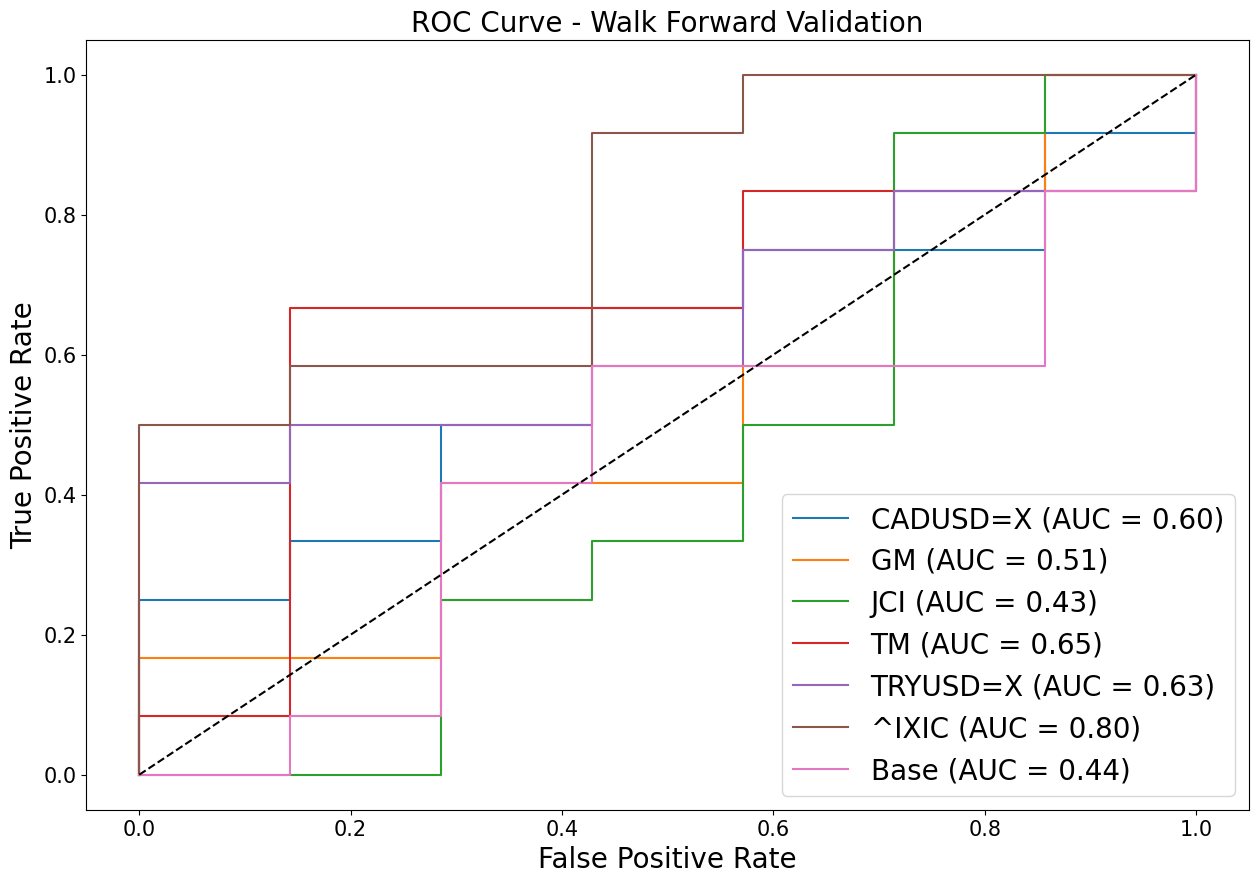

In [80]:
s='2024-11-04'
e='2024-11-29'

plt.figure(figsize=(15, 10))

for t in best_grid:
    if t == 'Base':
        forward = extract_cols(df_forward, 'F')
    else:
        forward = extract_cols(df_forward, t)

    m = np.where(df_forward.Date == s)[0][0]
    n = np.where(df_forward.Date == e)[0][0]

    model = models[t]

    forward_temp = forward.loc[m:n].copy()

    y_forward = forward_temp['Prediction']
    X_forward = forward_temp.drop(['Prediction'], axis = 1)

    y_pred_proba = model.predict_proba(X_forward)[:, 1]

    fpr, tpr, _ = roc_curve(y_forward, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{t} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve - Walk Forward Validation', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right', fontsize=20)
#plt.grid(True)
#plt.show()
plt.savefig('ROC_forward.jpg')